In [23]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
from scipy.stats import pearsonr, spearmanr
from scipy import stats
from IPython.display import display, HTML
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc, classification_report
from sklearn.model_selection import train_test_split
from datetime import datetime
from statsmodels.formula.api import ols
from statsmodels.stats.api import anova_lm
from IPython.display import display, HTML
from wordcloud import WordCloud
from nltk.corpus import stopwords
import nltk
from collections import Counter
nltk.download('stopwords')
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.precision', 3)
display(HTML("<style>.container { width:100% !important; }</style>"))
display(HTML("<style>div.output_scroll { height: unset; }</style>"))
display(HTML("<style>pre { white-space: pre !important; }</style>"))
import warnings
warnings.filterwarnings('ignore')



In [24]:
#loading the dataset
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

df_trustpilot = pd.read_csv('data/data_trustpilot.csv', engine='python')

display(df_trustpilot.head())



,rating,location,username,number_reviews,verification,verification_encoded,repeat_reviewer_encoded,company,text,text_processed,text_length,text_word_length,subject,subject_processed,subject_length,subject_word_length,answer,answer_processed,answered,date_of_experience,date_posted,local_date_posted,month_name_local_encoded,local_hour,time_of_day,time_of_day_encoded,day_of_week_posted,day_type_encoded,days_between_experience_and_post,review_time_encoded
0,5,CA,Rob Crane,2,Redirected,0,1,Flashbay,The company rep I worked with made my transaction smooth and quick. The samples were so helpful and the item shipping was relatively very fast. I will be a repeat customer.,company rep worked made transaction smooth quick samples helpful item shipping relatively fast repeat customer,110,15,The company rep I worked with made my…,company rep worked made,23,4,0,0,0,2024-06-15,2024-10-23 04:17:44,2024-10-22,10,21,Evening,2,1,1,129,0
1,5,US,Pat Anderson,1,Verified,1,0,Flashbay,I highly recommend using Flashbay. Immediately after ordering I heard from them and they were attentive to every little detail. I had notebooks shipped to Alaska for a conference and they arrived in perfect condition and delivered on time! Can't say enough good things about Flashbay!,highly recommend using flashbay immediately ordering heard attentive every little detail notebooks shipped alaska conference arrived perfect condition delivered time cant say enough good things flashbay,202,26,I highly recommend using Flashbay,highly recommend using flashbay,31,4,0,0,0,2024-10-16,2024-10-16 19:34:05,2024-10-16,10,12,Business Hours,3,2,1,0,1
2,5,CZ,Margarita Orlova,1,Verified,1,0,Flashbay,"I had the pleasure of working with Shelby Gibson on a large order that we needed to ship to different locations. Shelby was very responsive, very kind and helpful. The order process was smooth and the final products look great. Only positive feedback from my side.",pleasure working shelby gibson large order needed ship different locations shelby responsive kind helpful order process smooth final products look great positive feedback side,175,24,Great customer service,great customer service,22,3,0,0,0,2024-10-10,2024-10-17 10:27:44,2024-10-17,10,10,Business Hours,3,3,1,7,0
3,5,US,Paola Rivas,1,Verified,1,0,Flashbay,"I had a fantastic experience with Brian Truong. He was attentive, truly understood my needs, and provided all the support I needed. Excellent customer service—thank you!",fantastic experience brian truong attentive truly understood needs provided support needed excellent customer servicethank,122,14,Outstanding Support and Attentive Service,outstanding support attentive service,37,4,0,0,0,2024-10-21,2024-10-21 22:38:50,2024-10-21,10,15,Business Hours,3,0,1,0,1
4,5,CA,Fiona Mckelvey Keenan,3,Not Verified,0,1,Flashbay,"My number-one go-to for computer accessories. Rachel was superb. She responded to my every request immediately, and her communication was satisfactory enough to get all the answers I wanted. Highly recommend!",numberone goto computer accessories rachel superb responded every request immediately communication satisfactory enough get answers wanted highly recommend,155,18,My number-one go-to for computer…,numberone goto computer,23,3,0,0,0,2024-07-11,2024-10-23 04:09:05,2024-10-22,10,21,Evening,2,1,1,103,0


In [25]:
#First check
df_trustpilot['local_date_posted'] = pd.to_datetime(df_trustpilot['local_date_posted'])

print(df_trustpilot.columns)
display(df_trustpilot.info())

Index(['rating', 'location', 'username', 'number_reviews', 'verification',
       'verification_encoded', 'repeat_reviewer_encoded', 'company', 'text',
       'text_processed', 'text_length', 'text_word_length', 'subject',
       'subject_processed', 'subject_length', 'subject_word_length', 'answer',
       'answer_processed', 'answered', 'date_of_experience', 'date_posted',
       'local_date_posted', 'month_name_local_encoded', 'local_hour',
       'time_of_day', 'time_of_day_encoded', 'day_of_week_posted',
       'day_type_encoded', 'days_between_experience_and_post',
       'review_time_encoded'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64342 entries, 0 to 64341
Data columns (total 30 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   rating                            64342 non-null  int64         
 1   location                          64342 non-n

None

STAGE 1 - UNIVARIATE ANALYSIS

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

def is_binary(df, column_name):
    return df[column_name].nunique() == 2

def analyze_statistics(df, column_name):
    print(f"Statistical analysis for column: {column_name}")
    dtype = df[column_name].dtype
    if is_binary(df, column_name):
        print("Binary Variable Analysis:")
        value_counts = df[column_name].value_counts()
        percentages = df[column_name].value_counts(normalize=True) * 100
        print("Distribution:")
        for value, count in value_counts.items():
            pct = percentages[value]
            if column_name == 'repeat_reviewer_encoded':
                label = 'One-time reviewer' if value == 0 else 'Repeat reviewer'
            else:
                label = f"Value {value}"
            print(f"{label}: {count} ({pct:.1f}%)")
        print("Conclusions:")
        majority_pct = max(percentages)
        majority_class = value_counts.index[0]
        if column_name == 'repeat_reviewer_encoded':
            majority_label = 'one-time reviewers' if majority_class == 0 else 'repeat reviewers'
            print(f"→ The dataset is {'highly ' if majority_pct > 75 else ''}dominated by {majority_label} ({majority_pct:.1f}%)")
            print(f"→ The class distribution is {'imbalanced' if abs(percentages[0] - percentages[1]) > 20 else 'relatively balanced'}")
    elif np.issubdtype(dtype, np.number):
        print("Numeric Variable Analysis:")
        print("Basic Statistics:")
        desc_stats = df[column_name].describe()
        print(desc_stats)
        mode_value = df[column_name].mode()[0]
        mode_count = df[column_name].value_counts().iloc[0]
        mean_value = df[column_name].mean()
        median_value = df[column_name].median()
        print("Detailed Statistics:")
        print(f"Most common value: {mode_value} (appears {mode_count} times)")
        print(f"Mean: {mean_value:.2f}")
        print(f"Median: {median_value:.2f}")
        skewness = df[column_name].skew()
        kurtosis = df[column_name].kurtosis()
        print("Advanced Statistics with Interpretation:")
        print(f"Skewness: {skewness:.2f}")
        if abs(skewness) < 0.5:
            print("→ Distribution is fairly symmetric")
        elif abs(skewness) < 1:
            direction = "right" if skewness > 0 else "left"
            print(f"→ Distribution is moderately skewed to the {direction}")
        else:
            direction = "right" if skewness > 0 else "left"
            print(f"→ Distribution is highly skewed to the {direction}")
        print(f"Kurtosis: {kurtosis:.2f}")
        if kurtosis < 3:
            print("→ Distribution has lighter tails than normal (platykurtic)")
        elif kurtosis > 3:
            print("→ Distribution has heavier tails than normal (leptokurtic)")
        else:
            print("→ Distribution has normal-like tails (mesokurtic)")
        
        z_scores = np.abs(stats.zscore(df[column_name]))
        outliers = len(z_scores[z_scores > 3])
        outliers_pct = (outliers/len(df[column_name])*100)
        print(f"Outlier Analysis:")
        print(f"Outliers (|z-score| > 3): {outliers}")
        print(f"Outlier percentage: {outliers_pct:.2f}%")
        
        print("Overall Conclusions:")
        if abs(mean_value - median_value) > 1:
            print(f"→ Large disparity between mean ({mean_value:.2f}) and median ({median_value:.2f}) "
                  f"indicates significant skew in the distribution")
        if mode_value == 1:
            print(f"→ Most common value is 1 ({mode_count} occurrences), "
                  f"indicating majority are one-time reviewers")
        if abs(skewness) > 10:
            print("→ Extremely non-normal distribution with severe right skew")
            print("→ This suggests a few users with very high review counts are pulling the average up")
        if outliers/len(df[column_name]) < 0.02:
            print(f"→ Limited outliers ({outliers_pct:.2f}%) suggest the extreme values, "
                  f"while present, are not dominating the distribution")
        
        print("Recommendations:")
        if abs(skewness) > 3 or kurtosis > 10:
            print("→ Consider analyzing one-time and repeat reviewers separately")
            print("→ Be cautious with mean-based metrics; median might be more representative")
        
    elif df[column_name].dtype == 'object':
        print("Categorical Variable Analysis:")
        if df[column_name].str.len().max() < 50:
            value_counts = df[column_name].value_counts()
            value_percentages = df[column_name].value_counts(normalize=True) * 100
            
            print("Top 10 Categories (Count and Percentage):")
            for val, count, pct in zip(value_counts.index[:10], 
                                     value_counts[:10], 
                                     value_percentages[:10]):
                print(f"{val}: {count} ({pct:.1f}%)")
                
    elif np.issubdtype(dtype, np.datetime64):
        print("Datetime Variable Analysis:")
        print("Temporal Range:")
        print(f"Earliest: {df[column_name].min()}")
        print(f"Latest: {df[column_name].max()}")
        print(f"Range: {df[column_name].max() - df[column_name].min()}")
        print(f"Total unique dates: {df[column_name].nunique()}")

def create_visualizations(df, column_name):
    print(f"Visualizations for column: {column_name}")
    print(f"{'='*50}")
    
    if is_binary(df, column_name):
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
        value_counts = df[column_name].value_counts()
        value_counts.plot(kind='bar', ax=ax1)
        ax1.set_title('Distribution of Classes')
        ax1.set_ylabel('Count')
        if column_name == 'repeat_reviewer_encoded':
            ax1.set_xticklabels(['One-time', 'Repeat'], rotation=0)
        plt.subplot(122)
        colors = ['#ff9999', '#66b3ff']
        value_counts.plot(kind='pie', autopct='%1.1f%%', colors=colors)
        plt.title('Percentage Distribution')
        if column_name == 'repeat_reviewer_encoded':
            plt.legend(['One-time', 'Repeat'])
        plt.tight_layout()
        plt.show()
        
    else:
        dtype = df[column_name].dtype
        if np.issubdtype(dtype, np.number):
            fig = plt.figure(figsize=(20, 10))
            plt.subplot(231)
            sns.histplot(df[column_name], kde=True)
            plt.title('Distribution')
            plt.subplot(232)
            sns.boxplot(y=df[column_name])
            plt.title('Boxplot')
            plt.subplot(233)
            stats.probplot(df[column_name], dist="norm", plot=plt)
            plt.title('Q-Q Plot')
            if column_name == 'rating':
                plt.subplot(234)
                sns.boxplot(data=df, x='verification', y=column_name)
                plt.title('Rating by Verification Status')
                plt.xticks(rotation=45)
                plt.subplot(235)
                sns.boxplot(data=df, x='day_of_week_posted', y=column_name)
                plt.title('Rating by Day of Week')
                plt.xticks(rotation=45)
                plt.subplot(236)
                monthly_avg = df.groupby(df['local_date_posted'].dt.month)[column_name].mean()
                monthly_avg.plot(marker='o')
                plt.title('Average Rating by Month')
                plt.xticks(range(1,13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                                        'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
            
        elif df[column_name].dtype == 'object':
            if df[column_name].str.len().max() < 50:
                fig = plt.figure(figsize=(20, 10))
                plt.subplot(231)
                df[column_name].value_counts().head(10).plot(kind='bar')
                plt.title('Top 10 Categories')
                plt.xticks(rotation=45)
                plt.subplot(232)
                plt.pie(df[column_name].value_counts(normalize=True).head(5) * 100,
                       labels=df[column_name].value_counts().head(5).index,
                       autopct='%1.1f%%')
                plt.title('Top 5 Categories Distribution')
                
        elif np.issubdtype(dtype, np.datetime64):
            fig = plt.figure(figsize=(20, 10))
            plt.subplot(231)
            df[column_name].dt.year.value_counts().sort_index().plot(kind='bar')
            plt.title('Year Distribution')
            plt.subplot(232)
            df[column_name].dt.month.value_counts().sort_index().plot(kind='bar')
            plt.title('Month Distribution')
            plt.xticks(range(12), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                                  'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
            plt.subplot(233)
            df[column_name].dt.dayofweek.value_counts().sort_index().plot(kind='bar')
            plt.title('Day of Week Distribution')
            plt.xticks(range(7), ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
            
            if column_name in ['local_date_posted']:
                plt.subplot(234)
                df[column_name].dt.hour.value_counts().sort_index().plot(kind='bar')
                plt.title('Hour Distribution')
        
        plt.tight_layout()
        plt.show()

Statistical analysis for column: rating
Numeric Variable Analysis:
Basic Statistics:
count    64342.000
mean         3.505
std          1.691
min          1.000
25%          1.000
50%          4.000
75%          5.000
max          5.000
Name: rating, dtype: float64
Detailed Statistics:
Most common value: 5 (appears 31362 times)
Mean: 3.51
Median: 4.00
Advanced Statistics with Interpretation:
Skewness: -0.52
→ Distribution is moderately skewed to the left
Kurtosis: -1.45
→ Distribution has lighter tails than normal (platykurtic)
Outlier Analysis:
Outliers (|z-score| > 3): 0
Outlier percentage: 0.00%
Overall Conclusions:
→ Limited outliers (0.00%) suggest the extreme values, while present, are not dominating the distribution
Recommendations:
None
Visualizations for column: rating


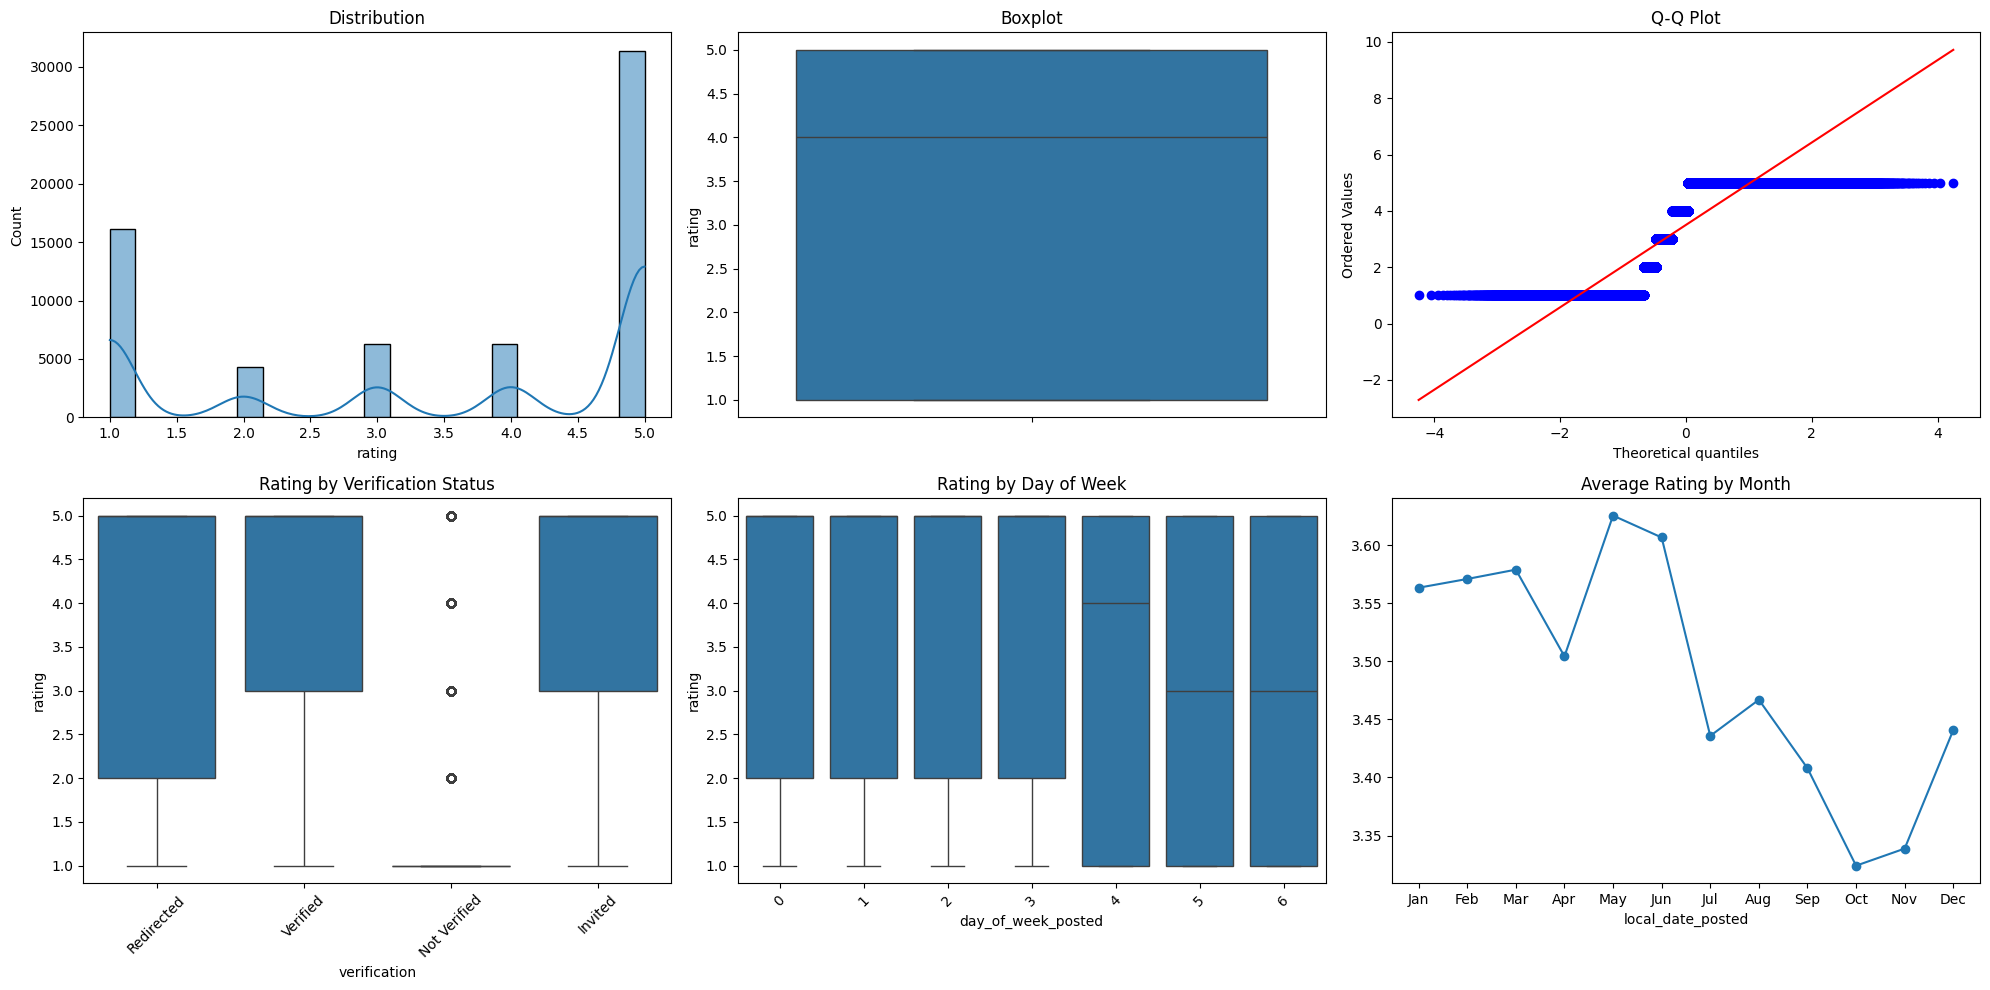

None


In [27]:
#Filtering out which columns not to consider because they are text-based
univariate_features = df_trustpilot.drop(['text', 'subject', 'answer', 'username'], axis=1)

print(analyze_statistics(df_trustpilot, univariate_features.columns[0]))
print(create_visualizations(df_trustpilot, univariate_features.columns[0]))

Statistical analysis for column: location
Categorical Variable Analysis:
Top 10 Categories (Count and Percentage):
US: 44104 (68.5%)
GB: 13702 (21.3%)
CA: 1394 (2.2%)
DE: 663 (1.0%)
NL: 361 (0.6%)
FR: 338 (0.5%)
AU: 304 (0.5%)
SE: 203 (0.3%)
DK: 190 (0.3%)
PL: 190 (0.3%)
None
Visualizations for column: location


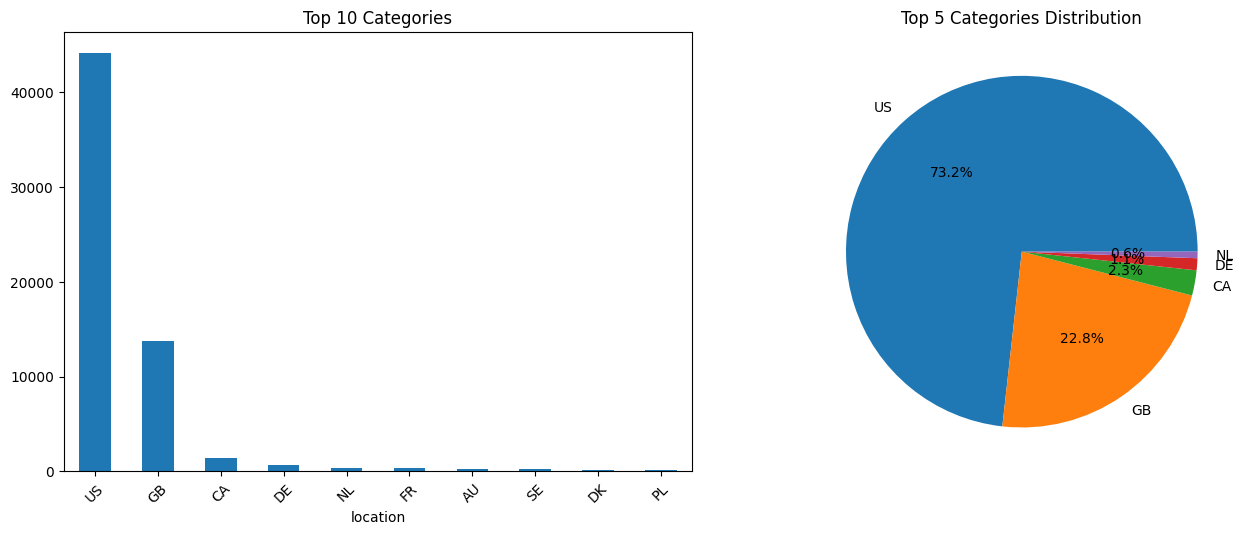

None


In [28]:
print(analyze_statistics(df_trustpilot, univariate_features.columns[1]))
print(create_visualizations(df_trustpilot, univariate_features.columns[1]))

Statistical analysis for column: number_reviews
Numeric Variable Analysis:
Basic Statistics:
count    64342.000
mean         3.681
std          9.882
min          1.000
25%          1.000
50%          1.000
75%          3.000
max        592.000
Name: number_reviews, dtype: float64
Detailed Statistics:
Most common value: 1 (appears 36145 times)
Mean: 3.68
Median: 1.00
Advanced Statistics with Interpretation:
Skewness: 15.85
→ Distribution is highly skewed to the right
Kurtosis: 520.31
→ Distribution has heavier tails than normal (leptokurtic)
Outlier Analysis:
Outliers (|z-score| > 3): 953
Outlier percentage: 1.48%
Overall Conclusions:
→ Large disparity between mean (3.68) and median (1.00) indicates significant skew in the distribution
→ Most common value is 1 (36145 occurrences), indicating majority are one-time reviewers
→ Extremely non-normal distribution with severe right skew
→ This suggests a few users with very high review counts are pulling the average up
→ Limited outliers (1.

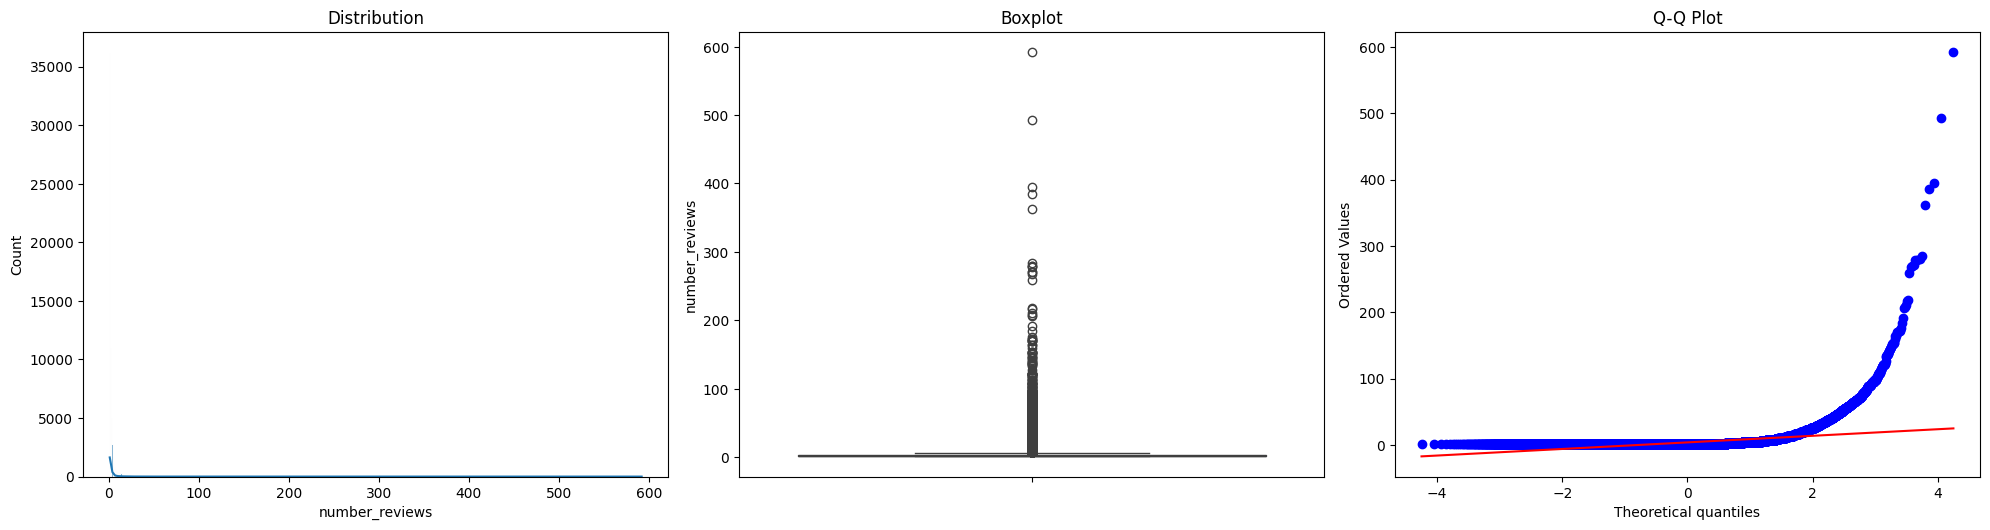

None


In [29]:
print(analyze_statistics(df_trustpilot, univariate_features.columns[2]))
print(create_visualizations(df_trustpilot, univariate_features.columns[2]))

Statistical analysis for column: verification
Categorical Variable Analysis:
Top 10 Categories (Count and Percentage):
Verified: 42108 (65.4%)
Not Verified: 13312 (20.7%)
Invited: 8913 (13.9%)
Redirected: 9 (0.0%)
None
Visualizations for column: verification


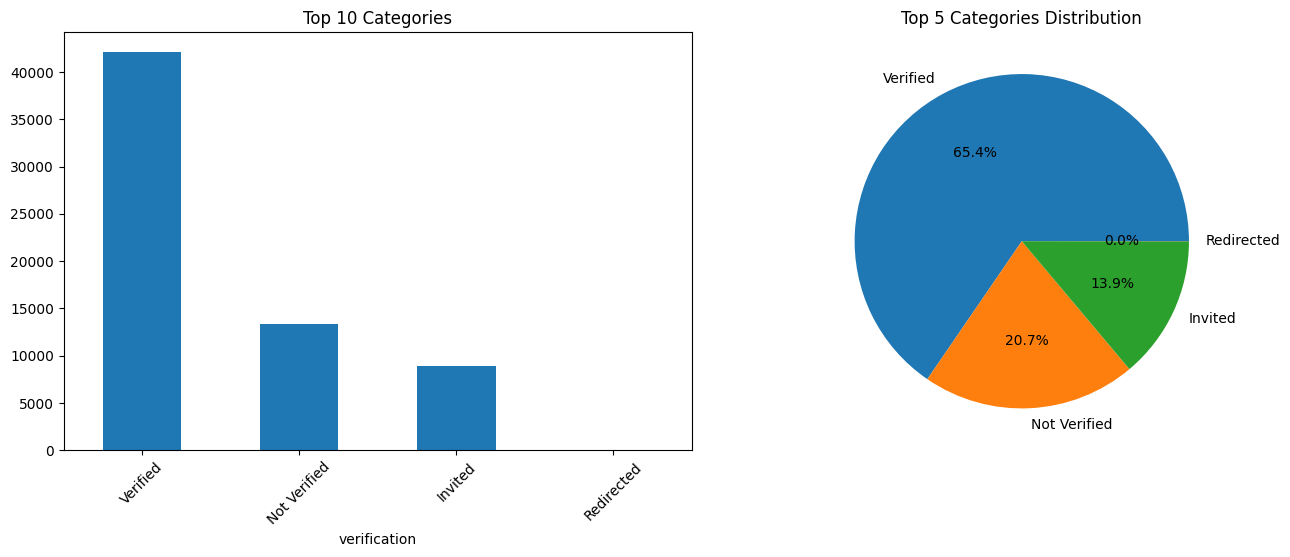

None


In [30]:
print(analyze_statistics(df_trustpilot, univariate_features.columns[3]))
print(create_visualizations(df_trustpilot, univariate_features.columns[3]))

Statistical analysis for column: verification_encoded
Binary Variable Analysis:
Distribution:
Value 1: 42108 (65.4%)
Value 0: 22234 (34.6%)
Conclusions:
None
Visualizations for column: verification_encoded


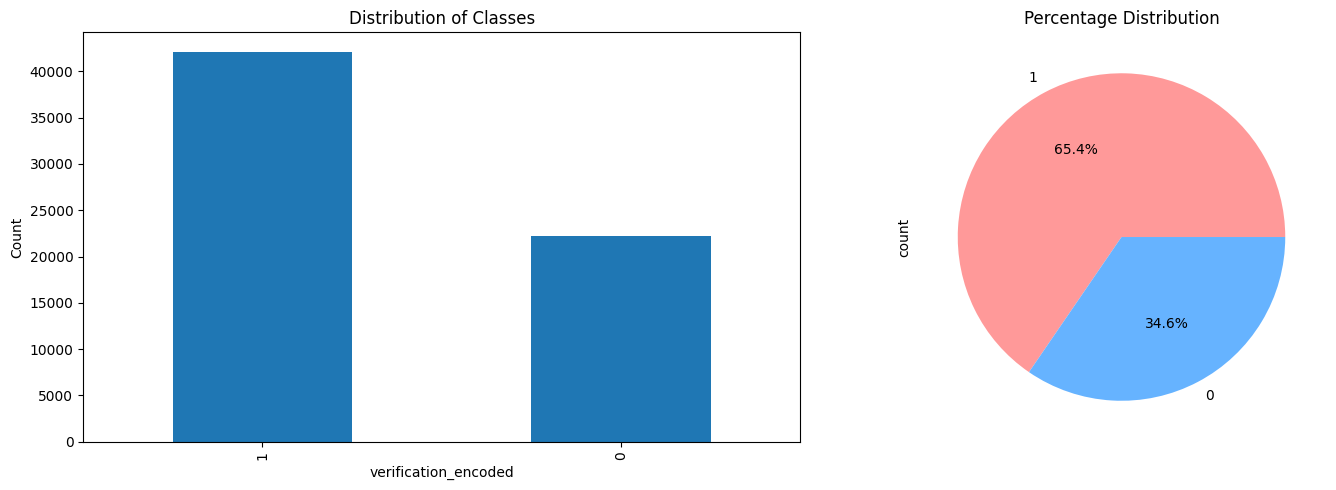

None


In [31]:
print(analyze_statistics(df_trustpilot, univariate_features.columns[4]))
print(create_visualizations(df_trustpilot, univariate_features.columns[4]))

Statistical analysis for column: repeat_reviewer_encoded
Binary Variable Analysis:
Distribution:
One-time reviewer: 36145 (56.2%)
Repeat reviewer: 28197 (43.8%)
Conclusions:
→ The dataset is dominated by one-time reviewers (56.2%)
→ The class distribution is relatively balanced
None
Visualizations for column: repeat_reviewer_encoded


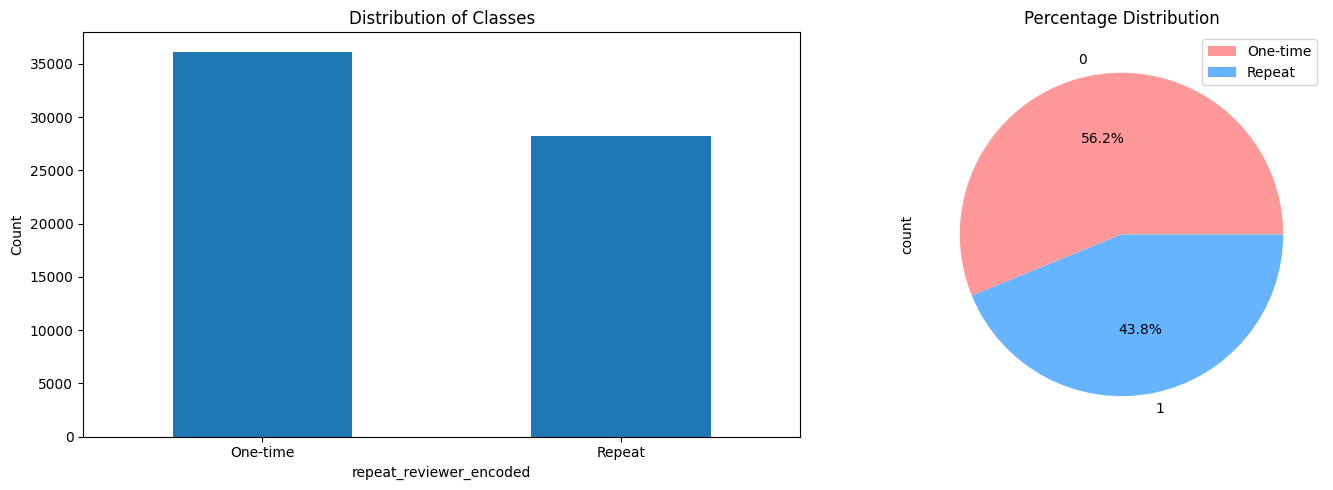

None


In [32]:
print(analyze_statistics(df_trustpilot, univariate_features.columns[5]))
print(create_visualizations(df_trustpilot, univariate_features.columns[5]))

Statistical analysis for column: company
Categorical Variable Analysis:
Top 10 Categories (Count and Percentage):
Quicken: 25279 (39.3%)
Flashbay: 14404 (22.4%)
SteelSeries: 12379 (19.2%)
Asda: 12280 (19.1%)
None
Visualizations for column: company


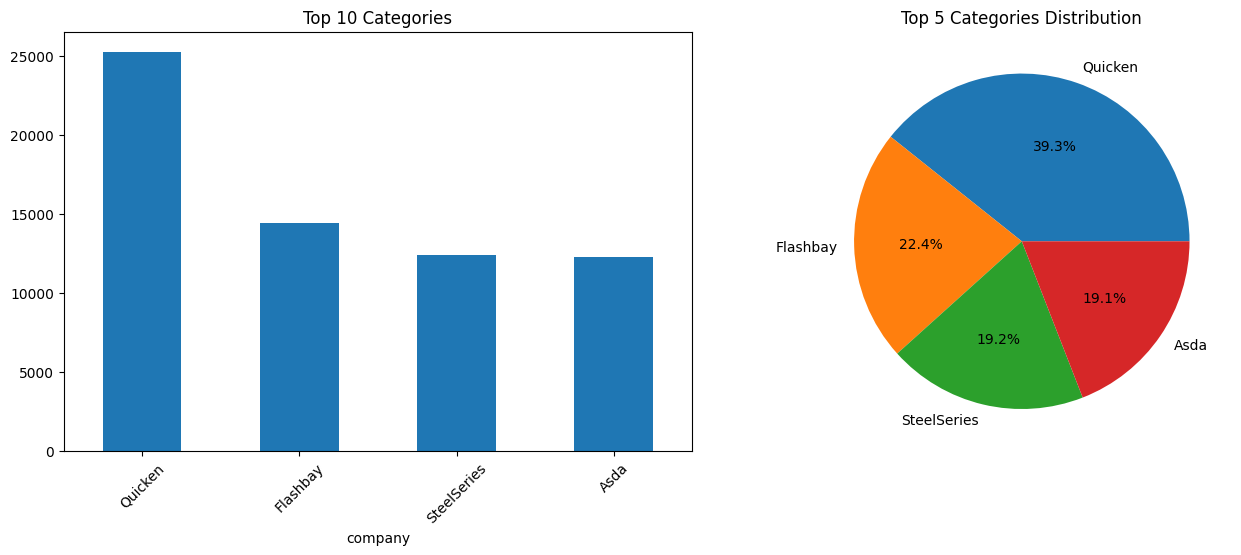

None


In [33]:
print(analyze_statistics(df_trustpilot, univariate_features.columns[6]))
print(create_visualizations(df_trustpilot, univariate_features.columns[6]))

In [34]:
print(analyze_statistics(df_trustpilot, univariate_features.columns[7]))
print(create_visualizations(df_trustpilot, univariate_features.columns[7]))

Statistical analysis for column: text_processed
Categorical Variable Analysis:
None
Visualizations for column: text_processed


<Figure size 640x480 with 0 Axes>

None


Statistical analysis for column: text_length
Numeric Variable Analysis:
Basic Statistics:
count    64342.000
mean       188.097
std        218.538
min          3.000
25%         66.000
50%        124.000
75%        228.000
max       8017.000
Name: text_length, dtype: float64
Detailed Statistics:
Most common value: 43 (appears 430 times)
Mean: 188.10
Median: 124.00
Advanced Statistics with Interpretation:
Skewness: 5.29
→ Distribution is highly skewed to the right
Kurtosis: 68.35
→ Distribution has heavier tails than normal (leptokurtic)
Outlier Analysis:
Outliers (|z-score| > 3): 1168
Outlier percentage: 1.82%
Overall Conclusions:
→ Large disparity between mean (188.10) and median (124.00) indicates significant skew in the distribution
→ Limited outliers (1.82%) suggest the extreme values, while present, are not dominating the distribution
Recommendations:
→ Consider analyzing one-time and repeat reviewers separately
→ Be cautious with mean-based metrics; median might be more represent

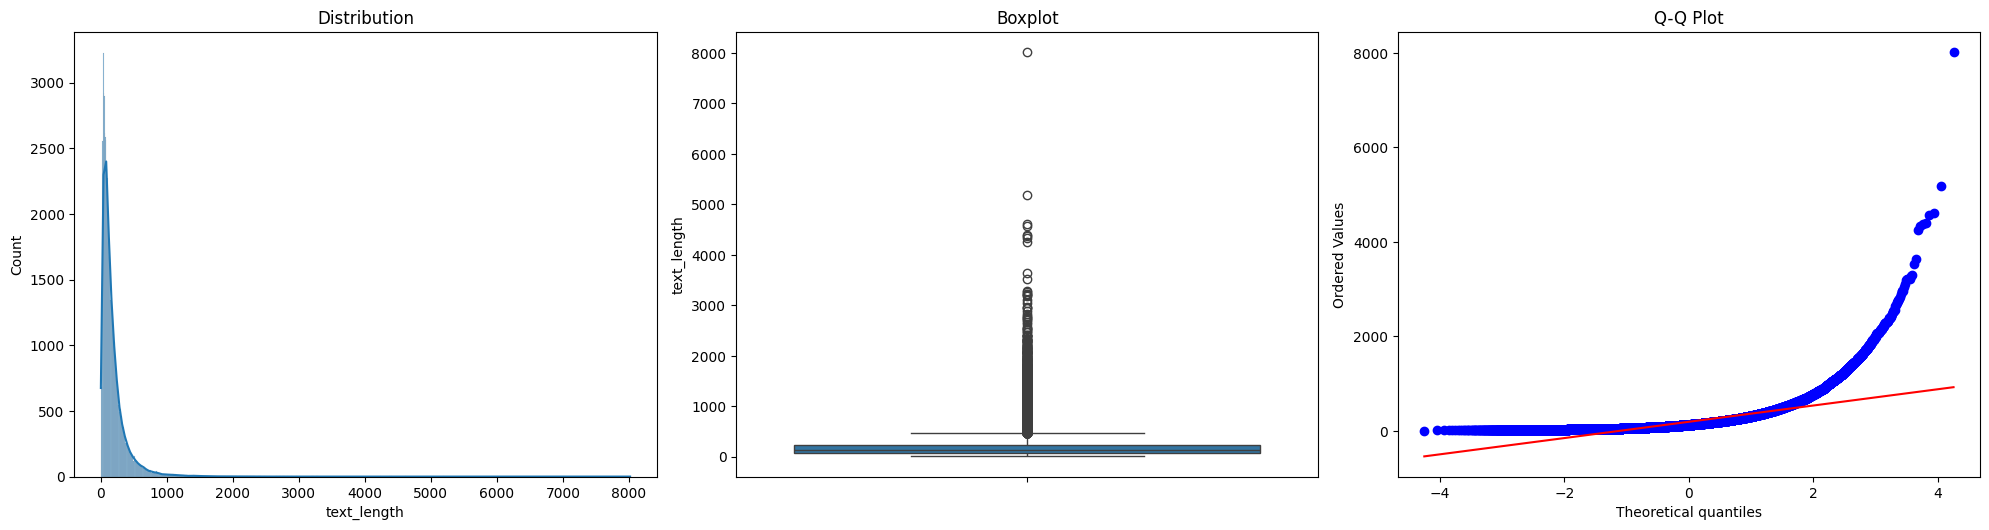

None


In [35]:
print(analyze_statistics(df_trustpilot, univariate_features.columns[8]))
print(create_visualizations(df_trustpilot, univariate_features.columns[8]))

Statistical analysis for column: text_word_length
Numeric Variable Analysis:
Basic Statistics:
count    64342.000
mean        27.140
std         31.971
min          1.000
25%          9.000
50%         18.000
75%         33.000
max       1089.000
Name: text_word_length, dtype: float64
Detailed Statistics:
Most common value: 6 (appears 2816 times)
Mean: 27.14
Median: 18.00
Advanced Statistics with Interpretation:
Skewness: 5.19
→ Distribution is highly skewed to the right
Kurtosis: 62.50
→ Distribution has heavier tails than normal (leptokurtic)
Outlier Analysis:
Outliers (|z-score| > 3): 1172
Outlier percentage: 1.82%
Overall Conclusions:
→ Large disparity between mean (27.14) and median (18.00) indicates significant skew in the distribution
→ Limited outliers (1.82%) suggest the extreme values, while present, are not dominating the distribution
Recommendations:
→ Consider analyzing one-time and repeat reviewers separately
→ Be cautious with mean-based metrics; median might be more rep

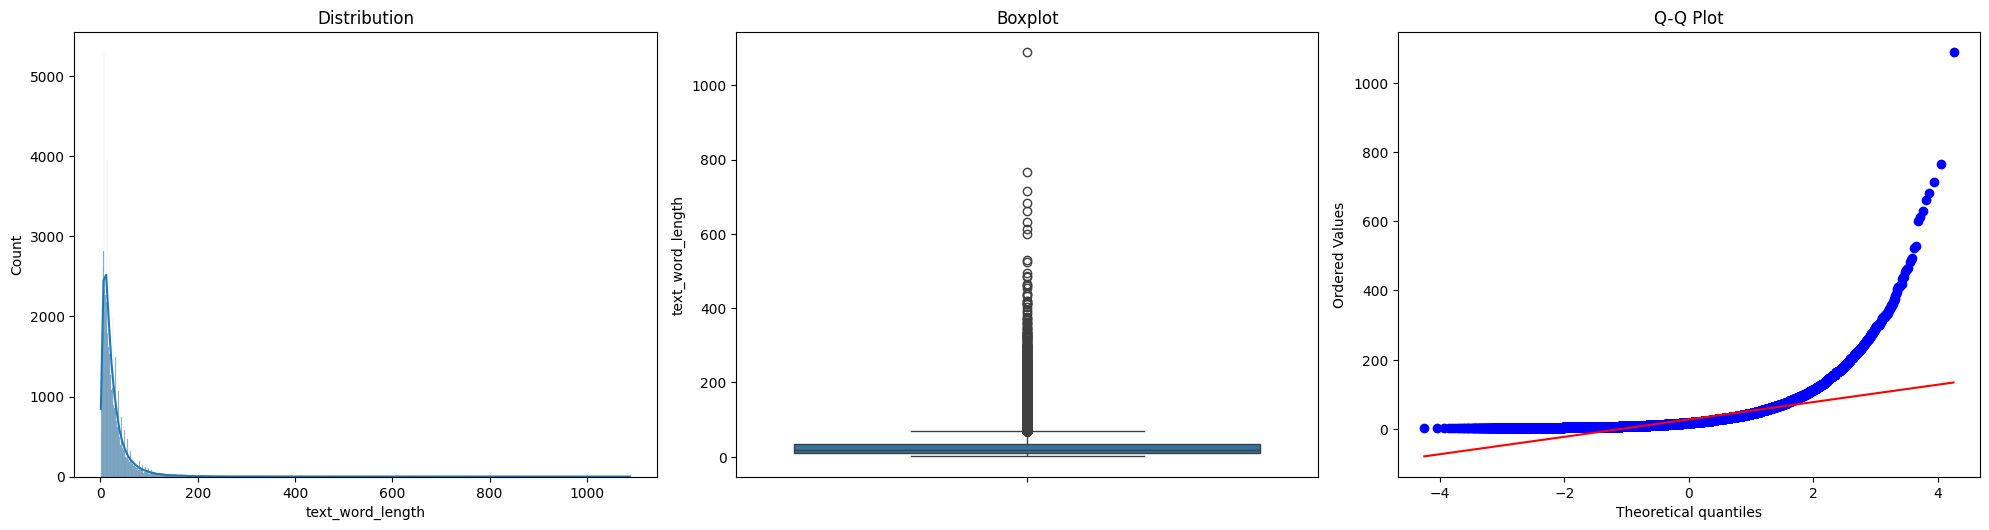

None


In [36]:
print(analyze_statistics(df_trustpilot, univariate_features.columns[9]))
print(create_visualizations(df_trustpilot, univariate_features.columns[9]))

In [37]:
print(analyze_statistics(df_trustpilot, univariate_features.columns[10]))
print(create_visualizations(df_trustpilot, univariate_features.columns[10]))

Statistical analysis for column: subject_processed
Categorical Variable Analysis:
None
Visualizations for column: subject_processed


<Figure size 640x480 with 0 Axes>

None


Statistical analysis for column: subject_length
Numeric Variable Analysis:
Basic Statistics:
count    64342.000
mean        23.717
std         10.648
min          0.000
25%         17.000
50%         23.000
75%         28.000
max        161.000
Name: subject_length, dtype: float64
Detailed Statistics:
Most common value: 22 (appears 3728 times)
Mean: 23.72
Median: 23.00
Advanced Statistics with Interpretation:
Skewness: 1.90
→ Distribution is highly skewed to the right
Kurtosis: 10.28
→ Distribution has heavier tails than normal (leptokurtic)
Outlier Analysis:
Outliers (|z-score| > 3): 913
Outlier percentage: 1.42%
Overall Conclusions:
→ Limited outliers (1.42%) suggest the extreme values, while present, are not dominating the distribution
Recommendations:
→ Consider analyzing one-time and repeat reviewers separately
→ Be cautious with mean-based metrics; median might be more representative
None
Visualizations for column: subject_length


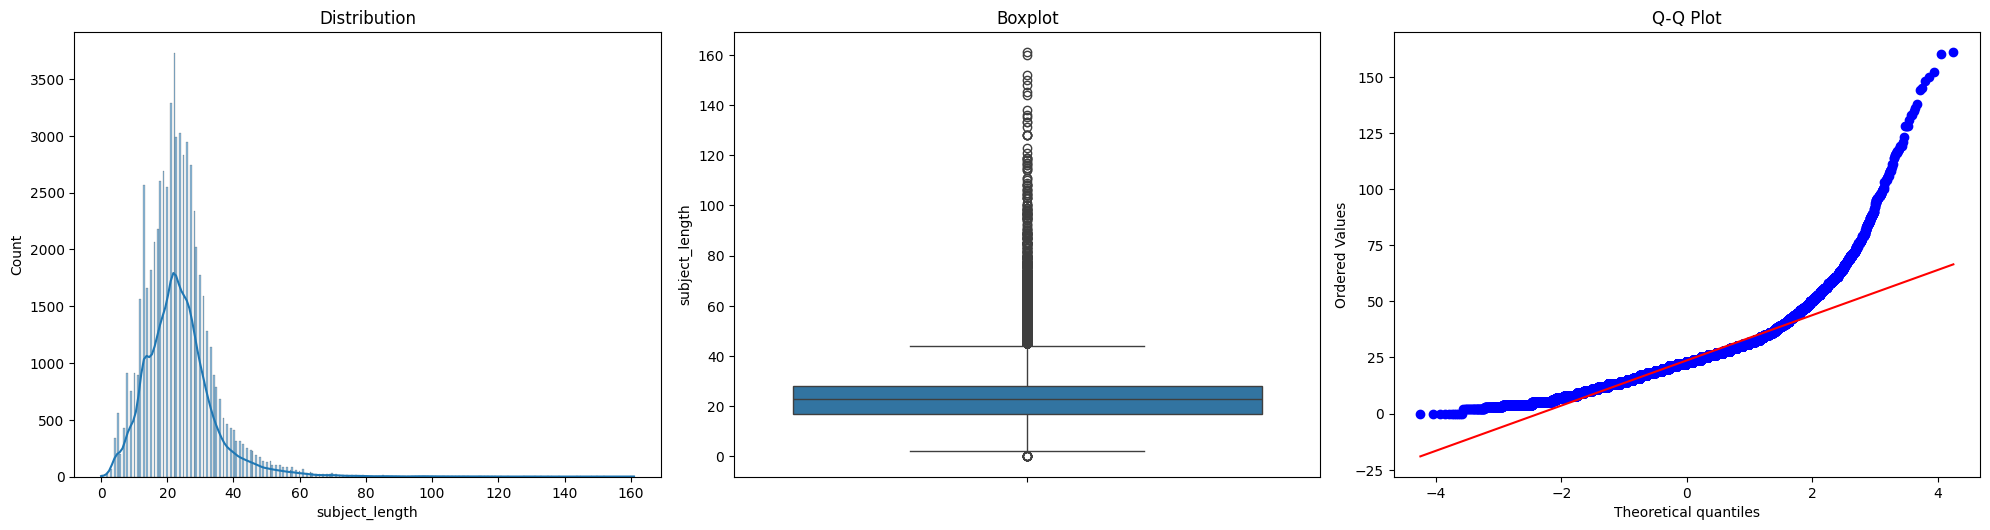

None


In [38]:
print(analyze_statistics(df_trustpilot, univariate_features.columns[11]))
print(create_visualizations(df_trustpilot, univariate_features.columns[11]))

Statistical analysis for column: subject_word_length
Numeric Variable Analysis:
Basic Statistics:
count    64342.000
mean         3.483
std          1.461
min          0.000
25%          3.000
50%          3.000
75%          4.000
max         27.000
Name: subject_word_length, dtype: float64
Detailed Statistics:
Most common value: 3 (appears 20868 times)
Mean: 3.48
Median: 3.00
Advanced Statistics with Interpretation:
Skewness: 1.93
→ Distribution is highly skewed to the right
Kurtosis: 11.43
→ Distribution has heavier tails than normal (leptokurtic)
Outlier Analysis:
Outliers (|z-score| > 3): 1014
Outlier percentage: 1.58%
Overall Conclusions:
→ Limited outliers (1.58%) suggest the extreme values, while present, are not dominating the distribution
Recommendations:
→ Consider analyzing one-time and repeat reviewers separately
→ Be cautious with mean-based metrics; median might be more representative
None
Visualizations for column: subject_word_length


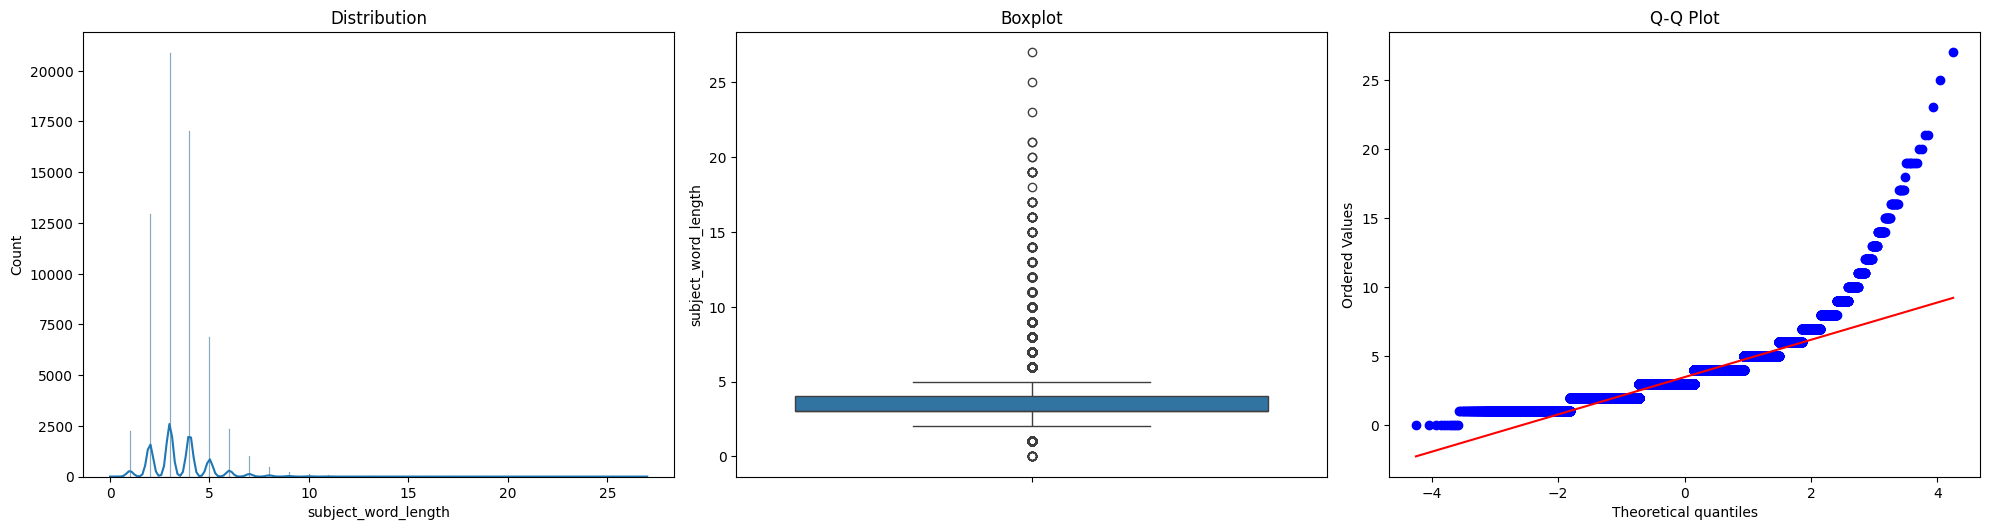

None


In [39]:
print(analyze_statistics(df_trustpilot, univariate_features.columns[12]))
print(create_visualizations(df_trustpilot, univariate_features.columns[12]))

In [ ]:
#Word Frequency plot

plt.figure(figsize=(12, 6))
word_freq = Counter(' '.join(df_trustpilot['text_processed']).split()).most_common(20)
words, counts = zip(*word_freq)
plt.bar(words, counts)
plt.xticks(rotation=45, ha='right')
plt.title('Top 20 Most Frequent Words')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

In [ ]:
#Word Length distribution

plt.figure(figsize=(10, 6))
word_lengths = [len(word) for word in ' '.join(df_trustpilot['text_processed']).split()]
sns.histplot(word_lengths, bins=20)
plt.title('Distribution of Word Lengths')
plt.xlabel('Word Length (characters)')
plt.ylabel('Count')
plt.show()

STAGE 2 - MULTIVARIATE ANALYSIS

In [40]:
def is_binary(df, column_name):
    return df[column_name].nunique() == 2

def analyze_multivariate(df, column_name, target='rating'):
    print(f"MULTIVARIATE ANALYSIS FOR {column_name}")
    if column_name in ['subject', 'text', 'answer']:
        print("Skipping text analysis column")
        return

    dtype = df[column_name].dtype

    if is_binary(df, column_name):
        print("Binary Variable Analysis:")
        values = sorted(df[column_name].unique())
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12))
        sns.violinplot(data=df, x=column_name, y=target, ax=ax1)
        if column_name == 'repeat_reviewer_encoded':
            ax1.set_xticklabels(['One-time', 'Repeat'])
        ax1.set_title(f'Distribution of {target} by {column_name}')
        sns.barplot(data=df, x=column_name, y=target, ax=ax2)
        if column_name == 'repeat_reviewer_encoded':
            ax2.set_xticklabels(['One-time', 'Repeat'])
        ax2.set_title(f'Mean {target} by {column_name}')
        plt.tight_layout()
        plt.show()
        
        print("Summary Statistics by Group:")
        summary = df.groupby(column_name)[target].agg([
            'count', 'mean', 'median', 'std'
        ]).round(2)
    
        if column_name == 'repeat_reviewer_encoded':
            summary.index = ['One-time', 'Repeat']
        print(summary)
    
        group_means = df.groupby(column_name)[target].mean()
        diff = group_means.iloc[1] - group_means.iloc[0]
        print(f"Difference in means (1 - 0): {diff:.2f}")
    
        print("Distribution of ratings by group:")
        rating_dist = pd.crosstab(df[column_name], df[target], normalize='index') * 100
        if column_name == 'repeat_reviewer_encoded':
            rating_dist.index = ['One-time', 'Repeat']
        print(rating_dist.round(2))
    
    elif np.issubdtype(dtype, np.number) and column_name != target:
        plt.figure(figsize=(10, 6))
        sns.scatterplot(data=df, x=column_name, y=target, alpha=0.5)
        plt.title(f'{target} vs {column_name}')
        plt.show()
        
        print("Grouped Statistics:")
        try:
            group_stats = df.groupby(pd.qcut(df[column_name], q=5, duplicates='drop'))[target].agg([
                'count', 'mean', 'median', 'std'
            ]).round(2)
            group_stats.index = ['Very Low', 'Low', 'Medium', 'High', 'Very High']
            print(group_stats)
        except ValueError:
            unique_values = sorted(df[column_name].unique())
            group_stats = df.groupby(column_name)[target].agg([
                'count', 'mean', 'median', 'std'
            ]).round(2)
            print(group_stats)
    
    elif dtype == 'object' or np.issubdtype(dtype, np.datetime64):
        if column_name == 'month_posted':
            month_map = {1: 'January', 2: 'February', 3: 'March', 4: 'April', 
                        5: 'May', 6: 'June', 7: 'July', 8: 'August',
                        9: 'September', 10: 'October', 11: 'November', 12: 'December'}
            
            fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
            sns.boxplot(data=df, x='month_posted', y=target, order=range(1,13), ax=ax1)
            ax1.set_xticklabels([month_map[i] for i in range(1,13)], rotation=45)
            ax1.set_title(f'Distribution of {target} by Month')
            monthly_stats = df.groupby('month_posted')[target].agg(['mean', 'std', 'count'])
            monthly_stats = monthly_stats.reindex(range(1,13))  
            
            sns.barplot(data=df, x='month_posted', y=target, ci='sd', 
                       order=range(1,13), ax=ax2)
            ax2.set_xticklabels([month_map[i] for i in range(1,13)], rotation=45)
            ax2.set_title(f'Mean {target} by Month (with standard deviation)')
            
            plt.tight_layout()
            plt.show()
            
            print("Monthly Statistics:")
            monthly_stats.index = [month_map[i] for i in range(1,13)]
            print(monthly_stats.round(2))
            
        else:
            top_categories = df[column_name].value_counts().head(10).index
            df_filtered = df[df[column_name].isin(top_categories)]
            fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
            sns.boxplot(data=df_filtered, x=column_name, y=target, ax=ax1)
            ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45)
            ax1.set_title(f'Distribution of {target} by {column_name}')
            summary = df_filtered.groupby(column_name)[target].agg(['mean', 'std', 'count'])
            summary['se'] = summary['std'] / np.sqrt(summary['count'])
        
            sns.barplot(data=df_filtered, x=column_name, y=target, ci='sd', ax=ax2)
            ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45)
            ax2.set_title(f'Mean {target} by {column_name} (with standard deviation)')
            plt.tight_layout()
            plt.show()
            
            print("Summary Statistics for Top 10 Categories:")
            print(summary.round(2))
            
            if column_name == 'company':
                print("Detailed Company Analysis:")
                for company in top_categories:
                    company_data = df[df['company'] == company]
                    print(f"{company}:")
                    print(f"Total reviews: {len(company_data):,}")
                    print(f"Average rating: {company_data[target].mean():.2f}")
                    if 'local_date_posted' in df.columns:
                        trend = (company_data.groupby(company_data['local_date_posted'].dt.year)[target].mean().iloc[-1] - 
                                company_data.groupby(company_data['local_date_posted'].dt.year)[target].mean().iloc[0])
                        print(f"Rating trend (start to end): {trend:.2f}")
                        recent_avg = company_data.tail(90)[target].mean()
                        print(f"Most recent average (last 3 months): {recent_avg:.2f}")


MULTIVARIATE ANALYSIS FOR location


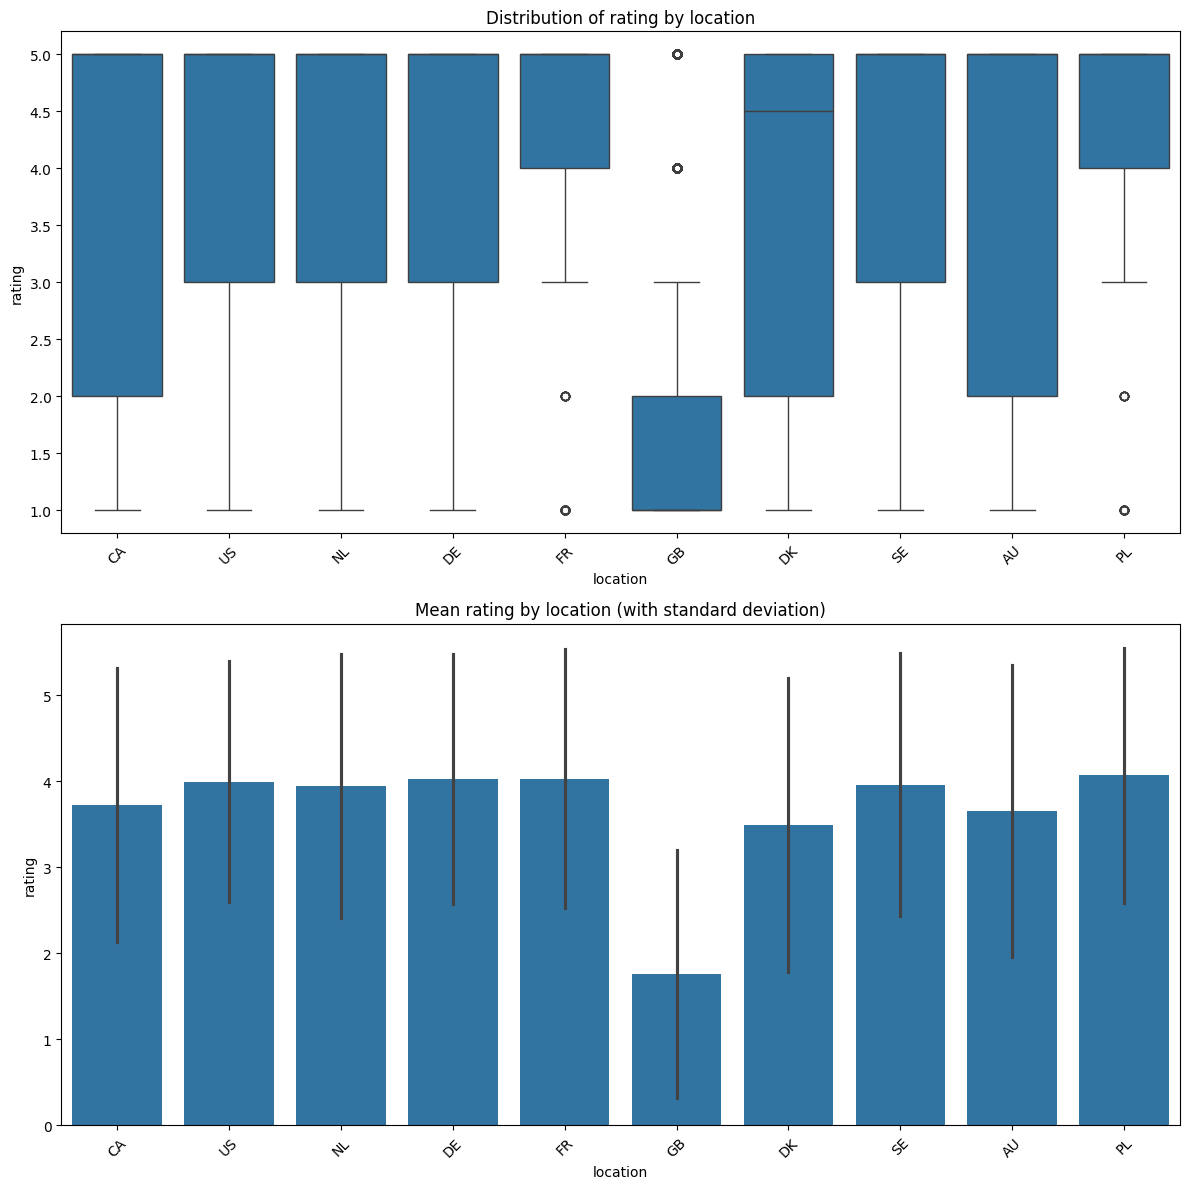

Summary Statistics for Top 10 Categories:
          mean   std  count    se
location                         
AU        3.66  1.70    304  0.10
CA        3.73  1.59   1394  0.04
DE        4.03  1.46    663  0.06
DK        3.49  1.71    190  0.12
FR        4.03  1.51    338  0.08
GB        1.76  1.44  13702  0.01
NL        3.95  1.53    361  0.08
PL        4.07  1.48    190  0.11
SE        3.96  1.53    203  0.11
US        4.00  1.40  44104  0.01
None


In [41]:
univariate_features = df_trustpilot.drop(['rating', 'username', 'month_name_local_encoded', 'local_hour', 'time_of_day', 'day_of_week_posted'], axis=1)

print(analyze_multivariate(df_trustpilot, univariate_features.columns[0], target='rating'))

MULTIVARIATE ANALYSIS FOR number_reviews


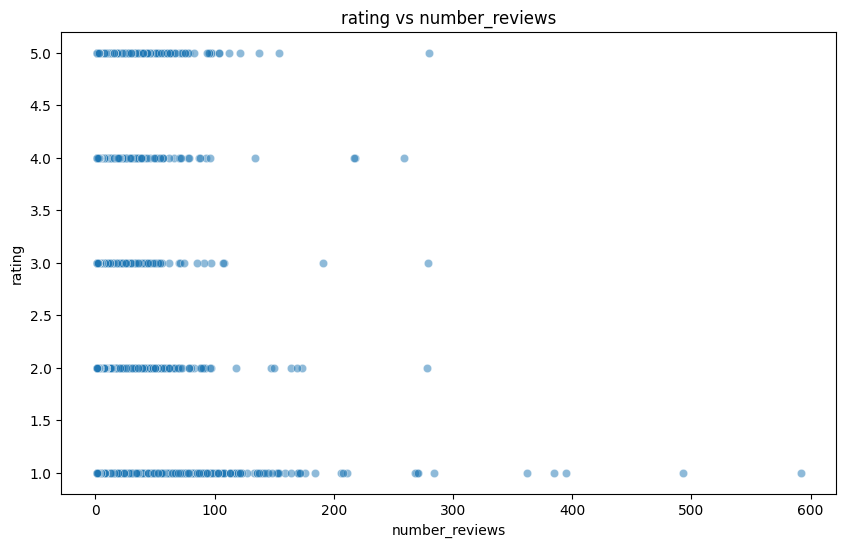

Grouped Statistics:
                count  mean  median   std
number_reviews                           
1               36145  3.88     5.0  1.54
2               11015  3.51     4.0  1.62
3                5028  3.37     4.0  1.67
4                2720  3.15     3.0  1.73
5                1671  2.95     3.0  1.75
6                1163  2.63     2.0  1.76
7                 827  2.44     1.0  1.77
8                 641  2.33     1.0  1.71
9                 516  2.17     1.0  1.63
10                427  2.05     1.0  1.62
11                380  2.21     1.0  1.65
12                319  2.01     1.0  1.55
13                291  2.01     1.0  1.59
14                234  1.78     1.0  1.44
15                215  1.84     1.0  1.48
16                189  1.88     1.0  1.53
17                142  1.66     1.0  1.34
18                158  1.70     1.0  1.38
19                144  1.99     1.0  1.60
20                 98  1.58     1.0  1.30
21                147  1.83     1.0  1.45
22            

In [42]:
print(analyze_multivariate(df_trustpilot, univariate_features.columns[1], target='rating'))

MULTIVARIATE ANALYSIS FOR verification


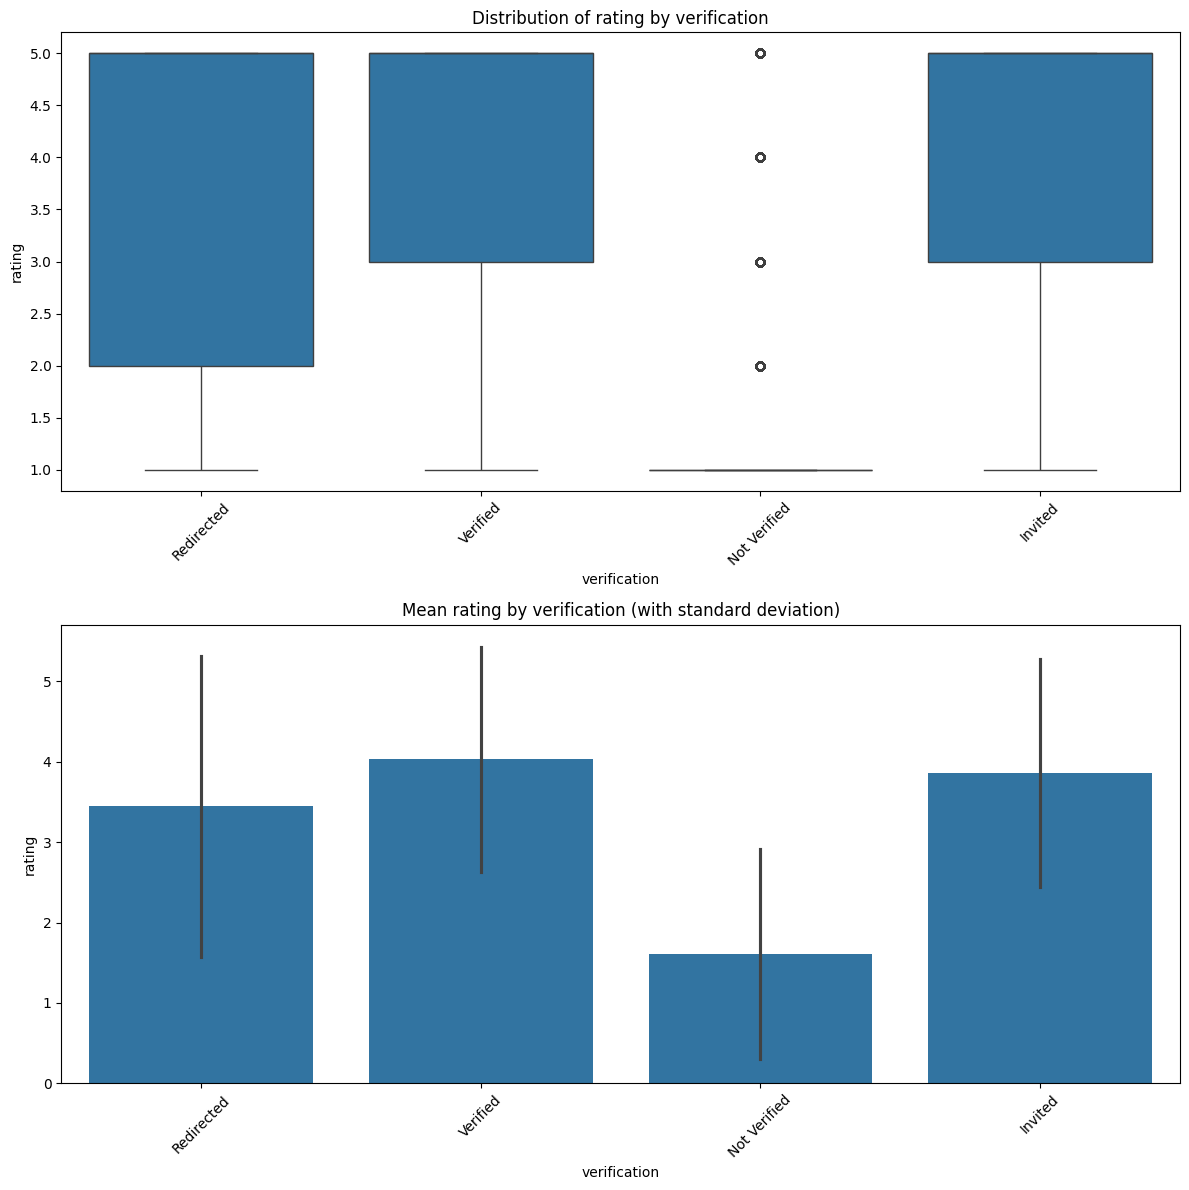

Summary Statistics for Top 10 Categories:
              mean   std  count    se
verification                         
Invited       3.86  1.42   8913  0.02
Not Verified  1.61  1.30  13312  0.01
Redirected    3.44  1.88      9  0.63
Verified      4.03  1.40  42108  0.01
None


In [43]:
print(analyze_multivariate(df_trustpilot, univariate_features.columns[2], target='rating'))

MULTIVARIATE ANALYSIS FOR verification_encoded
Binary Variable Analysis:


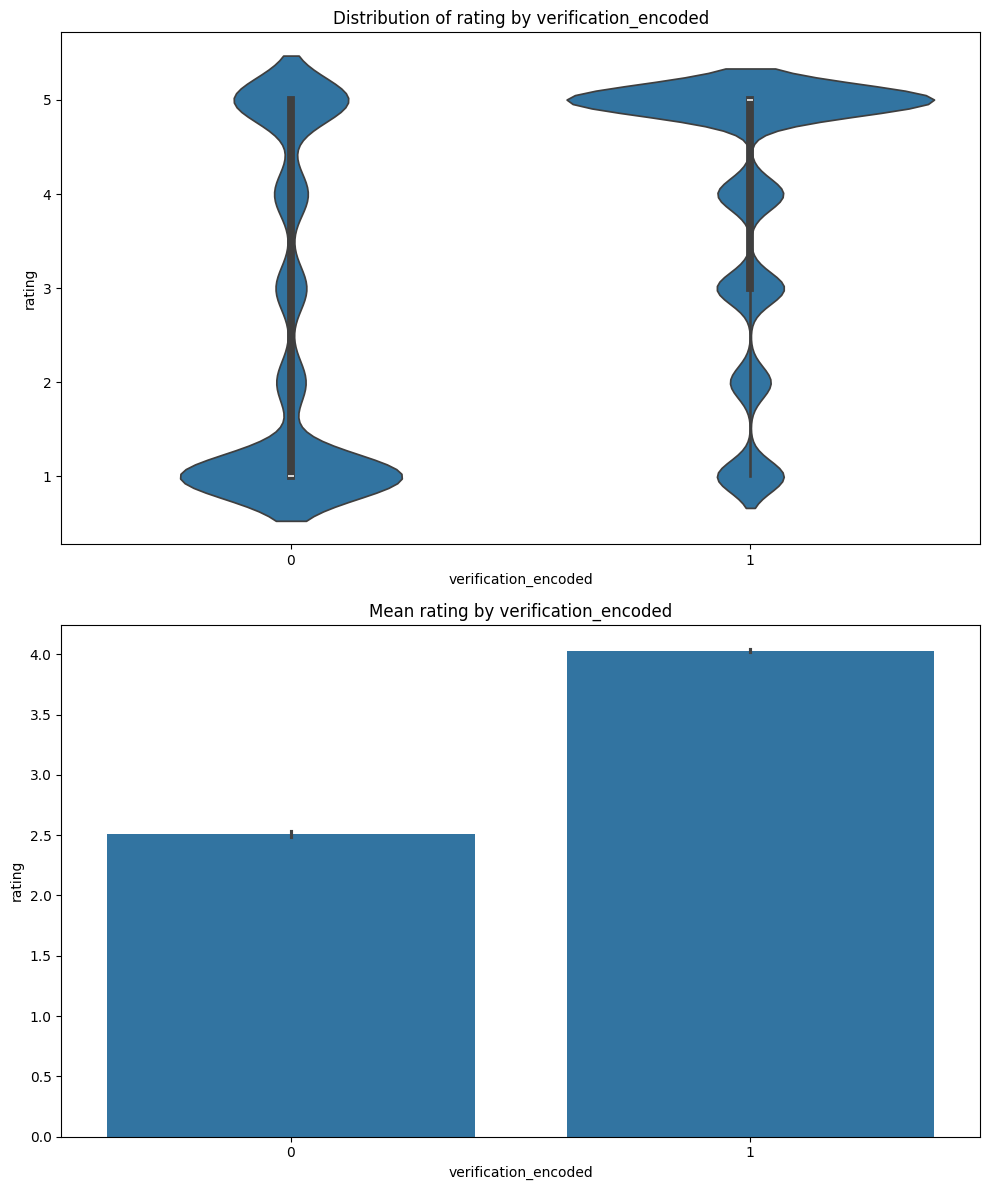

Summary Statistics by Group:
                      count  mean  median   std
verification_encoded                           
0                     22234  2.51     1.0  1.74
1                     42108  4.03     5.0  1.40
Difference in means (1 - 0): 1.52
Distribution of ratings by group:
rating                    1     2      3      4      5
verification_encoded                                  
0                     51.60  6.80   7.15   7.81  26.64
1                     10.98  6.69  11.09  10.83  60.41
None


In [44]:
print(analyze_multivariate(df_trustpilot, univariate_features.columns[3], target='rating'))

MULTIVARIATE ANALYSIS FOR repeat_reviewer_encoded
Binary Variable Analysis:


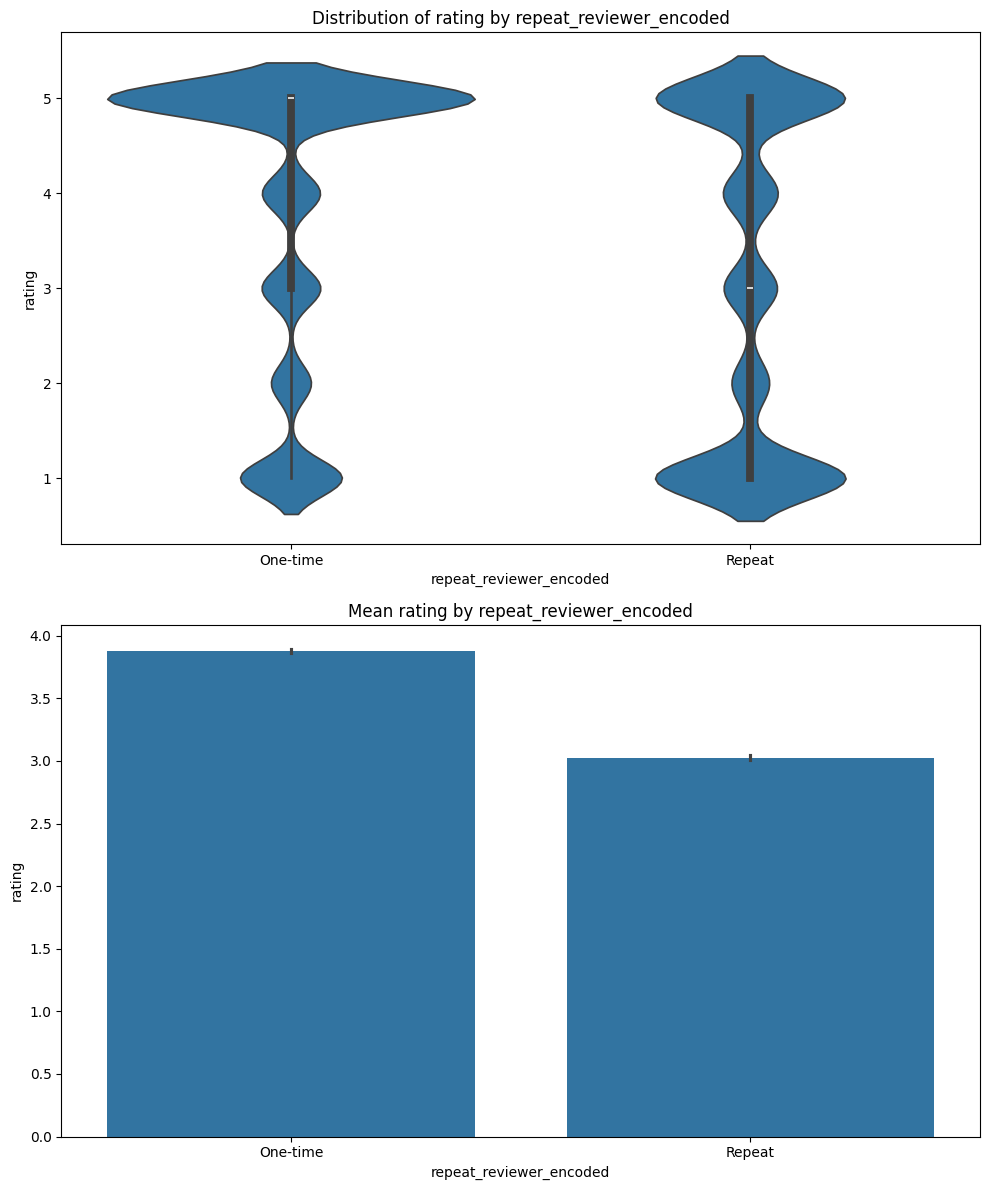

Summary Statistics by Group:
          count  mean  median   std
One-time  36145  3.88     5.0  1.54
Repeat    28197  3.03     3.0  1.75
Difference in means (1 - 0): -0.85
Distribution of ratings by group:
rating        1     2      3      4      5
One-time  16.26  6.39   9.39   9.28  58.68
Repeat    36.24  7.17  10.16  10.43  36.00
None


In [45]:
print(analyze_multivariate(df_trustpilot, univariate_features.columns[4], target='rating'))

MULTIVARIATE ANALYSIS FOR company


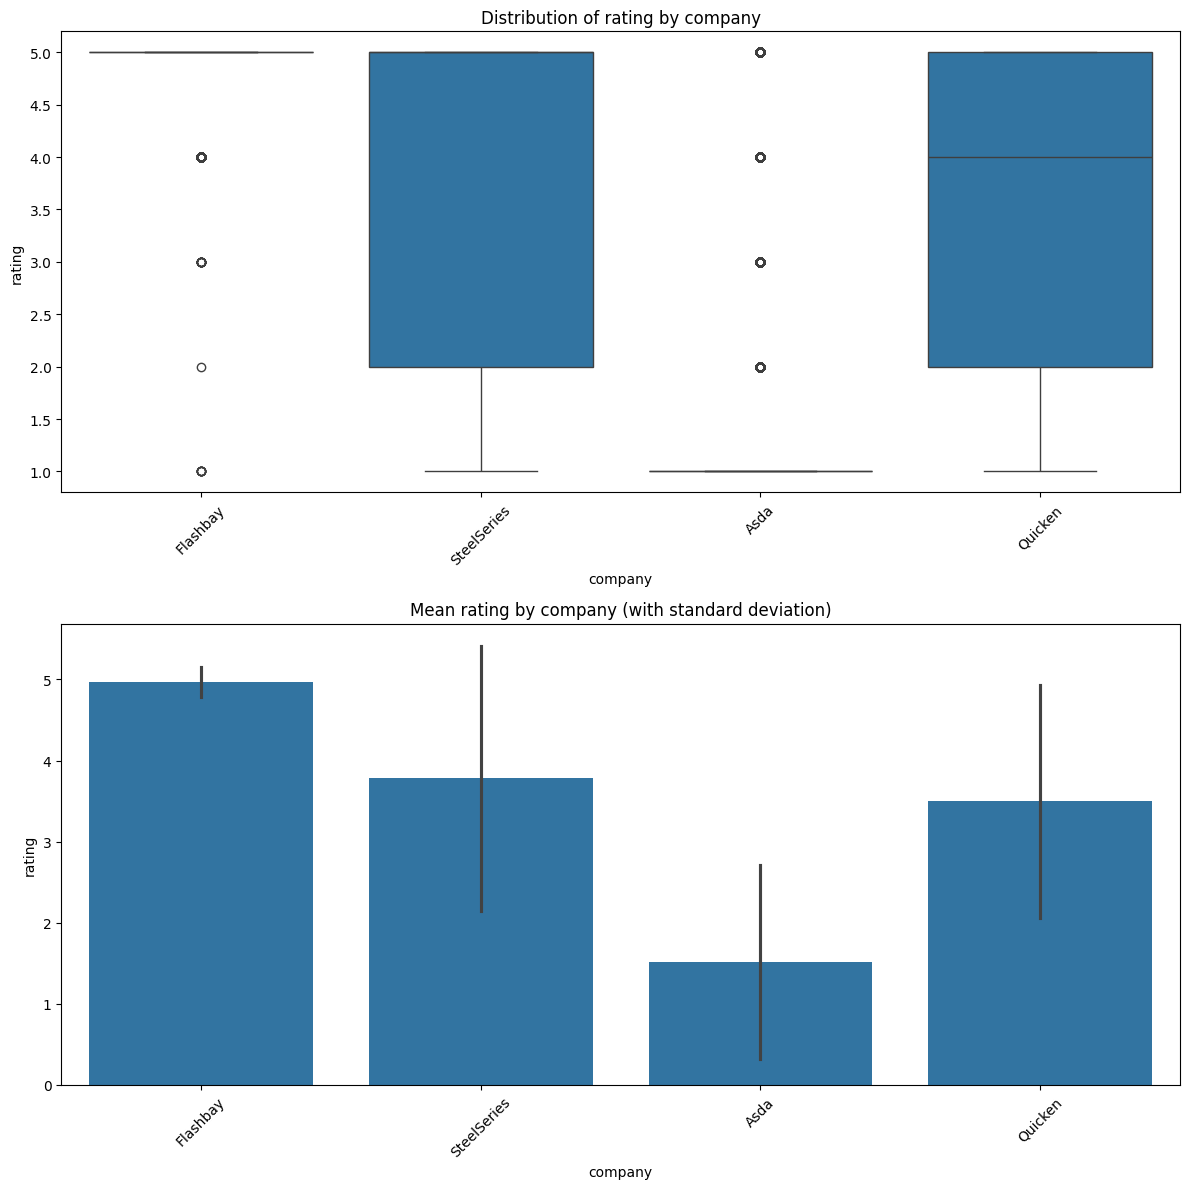

Summary Statistics for Top 10 Categories:
             mean   std  count    se
company                             
Asda         1.52  1.20  12280  0.01
Flashbay     4.97  0.19  14404  0.00
Quicken      3.50  1.44  25279  0.01
SteelSeries  3.78  1.63  12379  0.01
Detailed Company Analysis:
Quicken:
Total reviews: 25,279
Average rating: 3.50
Rating trend (start to end): -0.01
Most recent average (last 3 months): 2.46
Flashbay:
Total reviews: 14,404
Average rating: 4.97
Rating trend (start to end): 0.00
Most recent average (last 3 months): 4.93
SteelSeries:
Total reviews: 12,379
Average rating: 3.78
Rating trend (start to end): -1.96
Most recent average (last 3 months): 2.87
Asda:
Total reviews: 12,280
Average rating: 1.52
Rating trend (start to end): 0.35
Most recent average (last 3 months): 3.72
None


In [46]:
print(analyze_multivariate(df_trustpilot, univariate_features.columns[5], target='rating'))

In [47]:
print(analyze_multivariate(df_trustpilot, univariate_features.columns[6], target='rating'))

MULTIVARIATE ANALYSIS FOR text
Skipping text analysis column
None


MULTIVARIATE ANALYSIS FOR text_processed


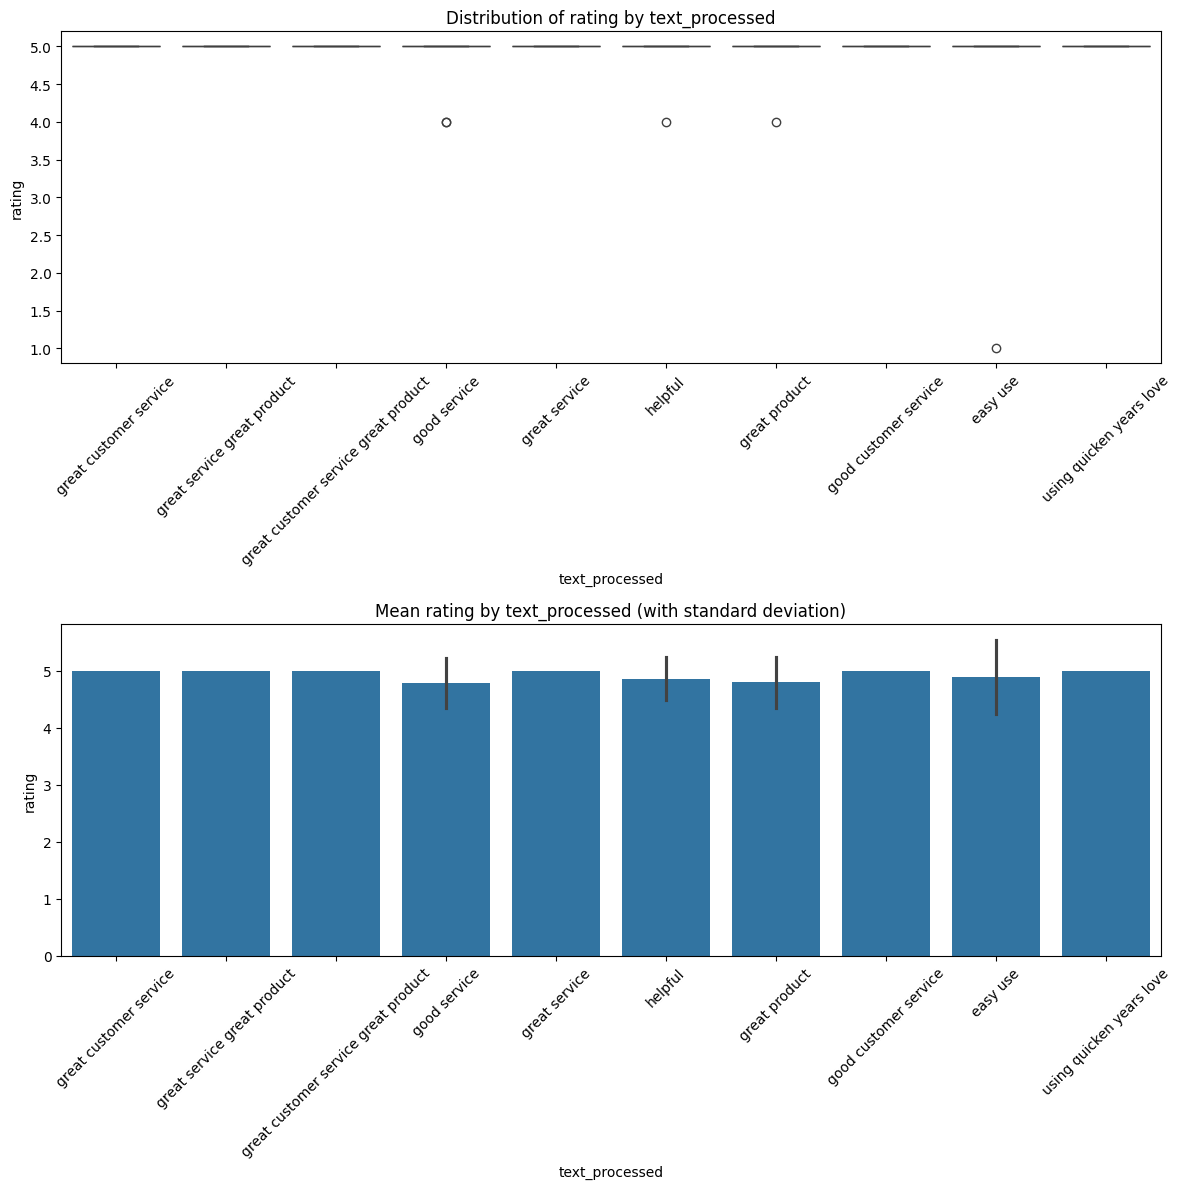

Summary Statistics for Top 10 Categories:
                                      mean   std  count    se
text_processed                                               
easy use                              4.89  0.65     38  0.11
good customer service                 5.00  0.00      6  0.00
good service                          4.78  0.44      9  0.15
great customer service                5.00  0.00     13  0.00
great customer service great product  5.00  0.00      6  0.00
great product                         4.80  0.45      5  0.20
great service                         5.00  0.00     11  0.00
great service great product           5.00  0.00     12  0.00
helpful                               4.86  0.38      7  0.14
using quicken years love              5.00  0.00      5  0.00
None


In [48]:
print(analyze_multivariate(df_trustpilot, univariate_features.columns[7], target='rating'))

MULTIVARIATE ANALYSIS FOR text_length


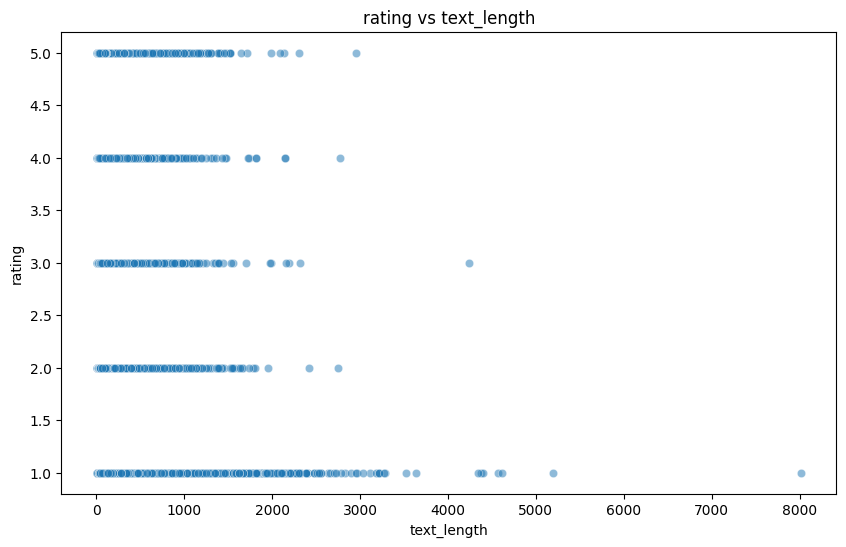

Grouped Statistics:
           count  mean  median   std
Very Low   12897  4.21     5.0  1.33
Low        13064  3.96     5.0  1.47
Medium     12802  3.74     5.0  1.58
High       12781  3.28     4.0  1.71
Very High  12798  2.32     1.0  1.66
None


In [49]:
print(analyze_multivariate(df_trustpilot, univariate_features.columns[8], target='rating'))

MULTIVARIATE ANALYSIS FOR text_word_length


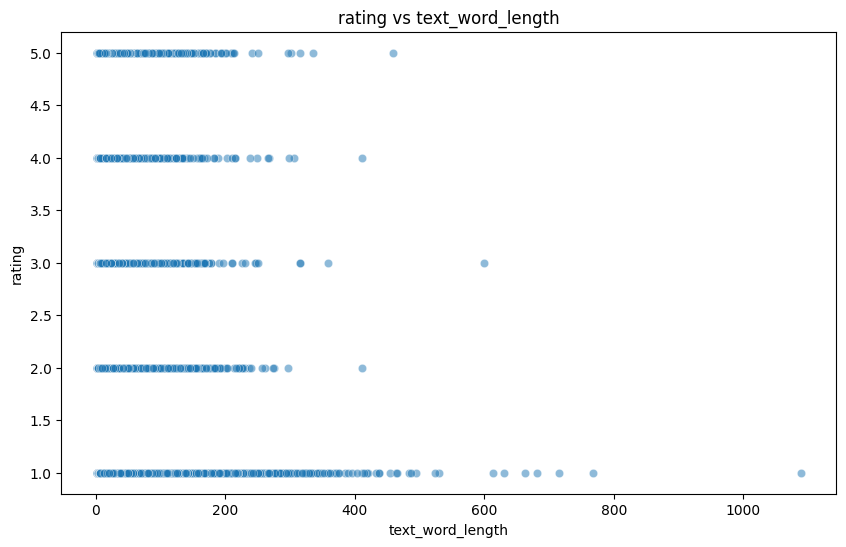

Grouped Statistics:
           count  mean  median   std
Very Low   13991  4.23     5.0  1.32
Low        13020  3.98     5.0  1.46
Medium     11988  3.75     5.0  1.56
High       12699  3.26     4.0  1.71
Very High  12644  2.23     1.0  1.62
None


In [50]:
print(analyze_multivariate(df_trustpilot, univariate_features.columns[9], target='rating'))

In [51]:
print(analyze_multivariate(df_trustpilot, univariate_features.columns[10], target='rating'))

MULTIVARIATE ANALYSIS FOR subject
Skipping text analysis column
None


In [ ]:
#Word length distribution by rating

plt.figure(figsize=(10, 6))
sns.boxplot(x='rating', y='text_word_length', data=df_trustpilot)
plt.title('Word Count Distribution by Rating')
plt.xlabel('Rating')
plt.ylabel('Number of Words')
plt.show()


In [ ]:
#Average word length by rating

df_trustpilot['avg_word_length'] = df_trustpilot['text_processed'].apply(lambda x: np.mean([len(word) for word in x.split()]))
plt.figure(figsize=(10, 6))
sns.boxplot(x='rating', y='avg_word_length', data=df_trustpilot)
plt.title('Average Word Length by Rating')
plt.xlabel('Rating')
plt.ylabel('Average Word Length')
plt.show()

In [52]:
print(df_trustpilot.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64342 entries, 0 to 64341
Data columns (total 30 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   rating                            64342 non-null  int64         
 1   location                          64342 non-null  object        
 2   username                          64340 non-null  object        
 3   number_reviews                    64342 non-null  int64         
 4   verification                      64342 non-null  object        
 5   verification_encoded              64342 non-null  int64         
 6   repeat_reviewer_encoded           64342 non-null  int64         
 7   company                           64342 non-null  object        
 8   text                              64342 non-null  object        
 9   text_processed                    64342 non-null  object        
 10  text_length                       64342 non-nu

In [53]:
#Split set into numeric, categorical and datetime variables
#Provide statistical metrics for numeric variables

numeric_variables = df_trustpilot.select_dtypes(include = ['int', 'float'])
categorical_variables = df_trustpilot.select_dtypes(include=['object']) 
datetime_variables = df_trustpilot.select_dtypes(include=['datetime64'])

STAGE 3 - TEXT-BASED VISUALIZATIONS

In [ ]:
#Creating positive and negative wordclouds

# stop words
stop_words = set(stopwords.words('english'))
stop_words.update(["product", "order", "I've", "could", "I'm", "u", "also", "tell"])


# splitting good and bad rated words
df_pos = df_trustpilot.loc[df_trustpilot["rating"]==5]

df_neg = df_trustpilot.loc[df_trustpilot["rating"]==1]


#creating positive word cloud
text = " ".join(df_pos["text"])
wordcloud = WordCloud(background_color="white", max_words=100, stopwords=stop_words, width = 800, height = 400). generate(text)

plt.figure(figsize = (10, 5))
plt.imshow(wordcloud, interpolation = "bilinear")
plt.axis("off")
plt.title("Word Cloud of positive ratings")
plt.show()


#creating negative word cloud
text = " ".join(df_neg["text"])
wordcloud = WordCloud(background_color="black", max_words=100, stopwords=stop_words, width = 800, height = 400). generate(text)

plt.figure(figsize = (10, 5))
plt.imshow(wordcloud, interpolation = "bilinear")
plt.title("Word Cloud of negative ratings")
plt.axis("off")
plt.show()


STAGE 4 - TIME SERIES PLOT

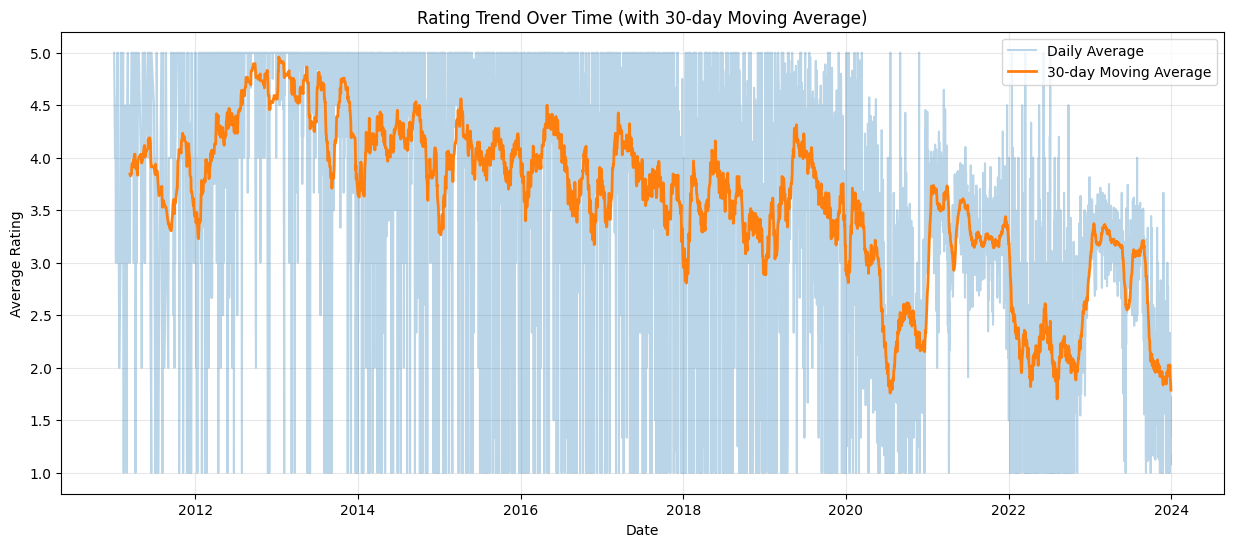

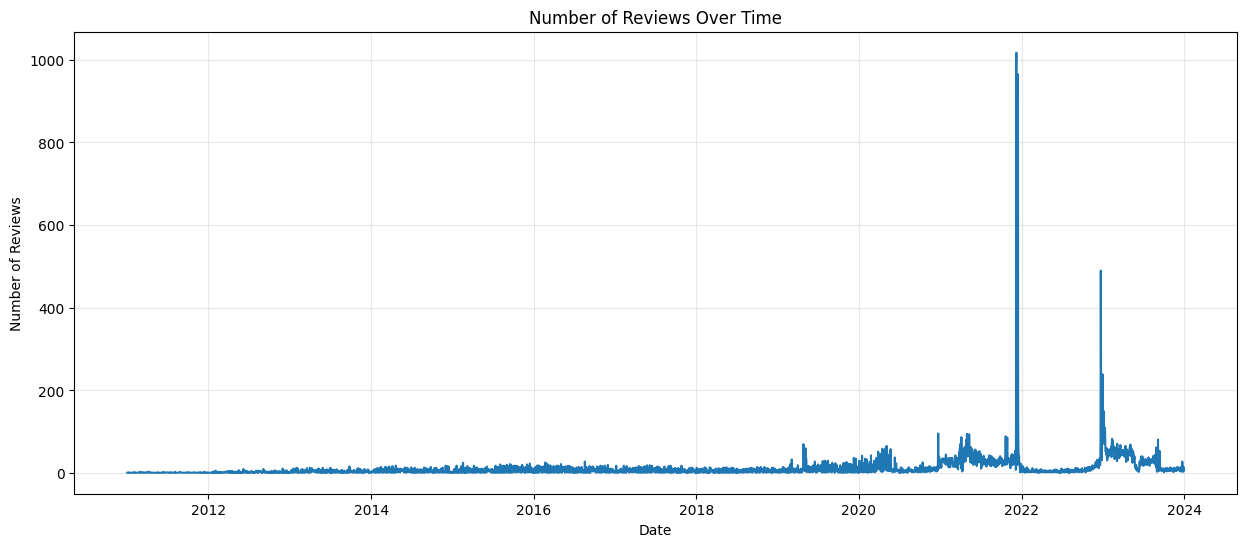

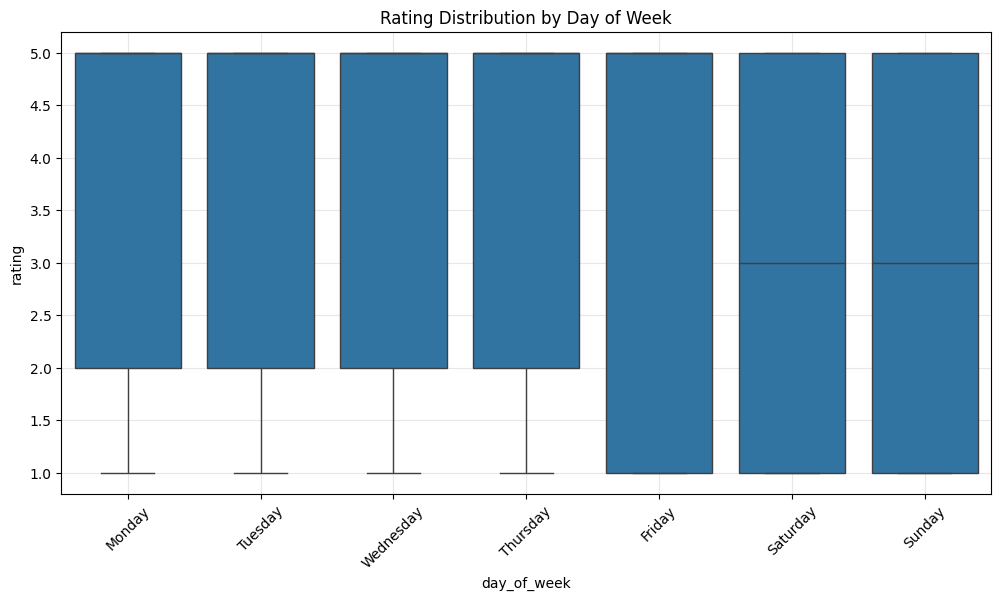

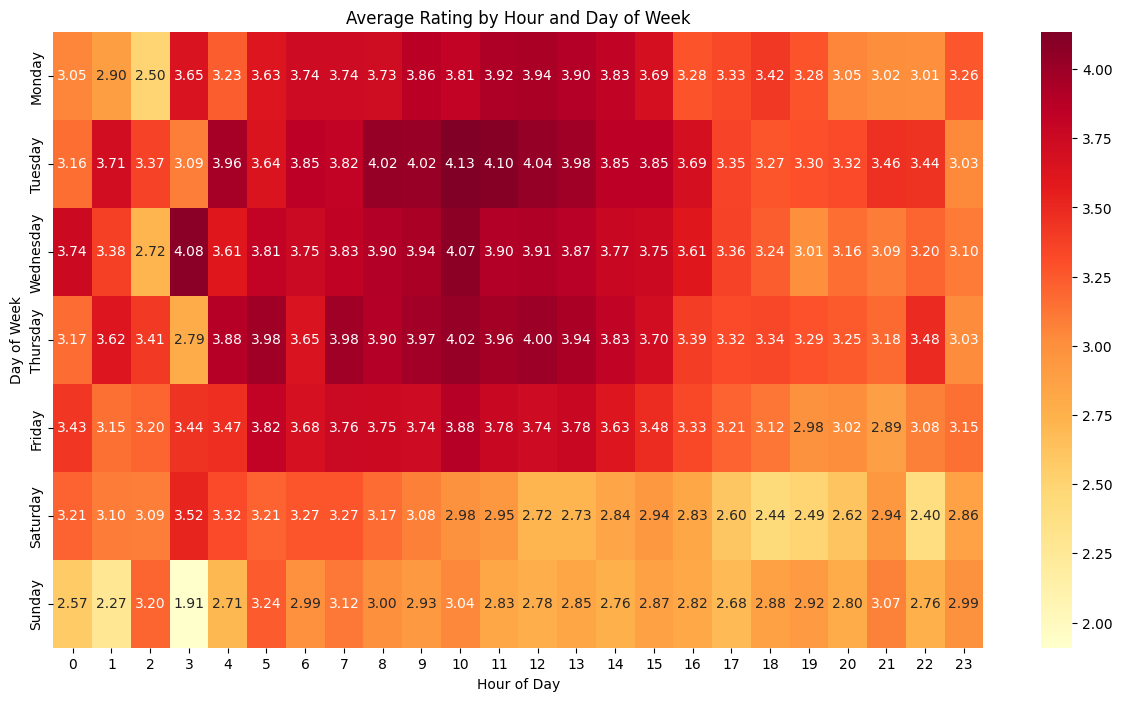

Time Series Statistics:
Start Date: 2011-01-02 00:00:00
End Date: 2023-12-31 00:00:00
Busiest Day: 2021-12-08 00:00:00 with 1017 reviews
Best Rating Day: 2011-01-02 00:00:00 with average rating of 5.00
Worst Rating Day: 2011-02-14 00:00:00 with average rating of 1.00


In [54]:

# Defining reasonable date range
start_date = '2011-01-01'
end_date = '2023-12-31'

# Filtering the data
filtered_df = df_trustpilot[
    (df_trustpilot['local_date_posted'] >= start_date) & 
    (df_trustpilot['local_date_posted'] <= end_date)
]

# Daily Average Rating Over Time 
daily_avg = filtered_df.groupby('local_date_posted')['rating'].mean()


# Rolling Average to Smooth Daily 
plt.figure(figsize=(15, 6))
rolling_avg = daily_avg.rolling(window=30).mean() 
plt.plot(daily_avg.index, daily_avg.values, alpha=0.3, label='Daily Average')
plt.plot(rolling_avg.index, rolling_avg.values, linewidth=2, label='30-day Moving Average')
plt.title('Rating Trend Over Time (with 30-day Moving Average)')
plt.xlabel('Date')
plt.ylabel('Average Rating')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Volume of Reviews Over Time
plt.figure(figsize=(15, 6))
daily_count = filtered_df.groupby('local_date_posted').size()
plt.plot(daily_count.index, daily_count.values)
plt.title('Number of Reviews Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Reviews')
plt.grid(True, alpha=0.3)
plt.show()

# Day of Week Analysis
plt.figure(figsize=(12, 6))
filtered_df['day_of_week'] = filtered_df['local_date_posted'].dt.day_name()
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
sns.boxplot(data=filtered_df, x='day_of_week', y='rating', order=day_order)
plt.title('Rating Distribution by Day of Week')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.show()

# Heatmap: Hour vs Day of Week
plt.figure(figsize=(15, 8))
pivot_table = filtered_df.pivot_table(
    values='rating',
    index=filtered_df['local_date_posted'].dt.day_name(),
    columns='local_hour',
    aggfunc='mean'
)
pivot_table = pivot_table.reindex(day_order)  
sns.heatmap(pivot_table, cmap='YlOrRd', annot=True, fmt='.2f')
plt.title('Average Rating by Hour and Day of Week')
plt.xlabel('Hour of Day')
plt.ylabel('Day of Week')
plt.show()


# Print summary statistics
print("Time Series Statistics:")
print(f"Start Date: {filtered_df['local_date_posted'].min()}")
print(f"End Date: {filtered_df['local_date_posted'].max()}")
print(f"Busiest Day: {daily_count.idxmax()} with {daily_count.max()} reviews")
print(f"Best Rating Day: {daily_avg.idxmax()} with average rating of {daily_avg.max():.2f}")
print(f"Worst Rating Day: {daily_avg.idxmin()} with average rating of {daily_avg.min():.2f}")

STAGE 5 - GROUPBY ANALYSES

In [55]:
# Location
print("LOCATION ANALYSIS")

# Get top 10 locations and filter DataFrame
top_locations = df_trustpilot['location'].value_counts().head(10).index
df_filtered = df_trustpilot[df_trustpilot['location'].isin(top_locations)]

# Basic metrics by location
location_analysis = df_filtered.groupby('location').agg({
    'rating': ['count', 'mean', 'std', 'median'],
    'repeat_reviewer_encoded': 'mean',
    'verification': 'mean'
}).round(3)

# Rename columns
location_analysis.columns = ['Total_Reviews', 'Avg_Rating', 'Std_Rating', 'Median_Rating', 
                           'Pct_Repeat_Reviewers', 'Pct_Verified']
print("Basic Location Metrics:")
print(location_analysis)

# Day of week distribution by location
day_distribution = pd.crosstab(df_filtered['location'], 
                              df_filtered['day_of_week_posted'], 
                              normalize='index').round(3) * 100
print("Day of Week Distribution by Location (%):")
print(day_distribution)

# Time of day distribution by location
time_distribution = pd.crosstab(df_filtered['location'], 
                               df_filtered['time_of_day'], 
                               normalize='index').round(3) * 100
print("Time of Day Distribution by Location (%):")
print(time_distribution)

# Rating distribution by location
rating_distribution = pd.crosstab(df_filtered['location'], 
                                 df_filtered['rating'], 
                                 normalize='index').round(3) * 100
print("Rating Distribution by Location (%):")
print(rating_distribution)

# Recent trends (last 90 days)
recent_cutoff = df_filtered['local_date_posted'].max() - pd.Timedelta(days=90)
recent_data = df_filtered[df_filtered['local_date_posted'] >= recent_cutoff]

recent_analysis = recent_data.groupby('location').agg({
    'rating': ['count', 'mean'],
    'verification': 'mean',
    'repeat_reviewer_encoded': 'mean'
}).round(3)

recent_analysis.columns = ['Recent_Review_Count', 'Recent_Avg_Rating', 
                         'Recent_Verification_Rate', 'Recent_Repeat_Reviewer_Rate']
print("Recent 90-Day Metrics by Location:")
print(recent_analysis)

colors = sns.color_palette("husl", n_colors=len(top_locations))
plt.figure(figsize=(15, 8))
sns.boxplot(x='location', y='rating', data=df_filtered,
            palette=colors,
            boxprops={'zorder': 1},
            showfliers=False)
sns.stripplot(x='location', y='rating', data=df_filtered,
              palette=colors,
              size=4,
              jitter=0.2,
              zorder=2)
plt.title('Rating Distribution by Top 10 Countries', fontsize=14, pad=20)
plt.xlabel('Country', fontsize=12)
plt.ylabel('Rating', fontsize=12)
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

top_5_locations = df_trustpilot['location'].value_counts().head(5).index
df_filtered_top5 = df_filtered[df_filtered['location'].isin(top_5_locations)]

# Year over Year Analysis (Top 5)
plt.figure(figsize=(15, 6))
for location in top_5_locations:
    yearly_avg = df_filtered_top5[df_filtered_top5['location'] == location].groupby(
        df_filtered_top5['local_date_posted'].dt.year)['rating'].mean()
    plt.plot(yearly_avg.index, yearly_avg.values, marker='o', label=location)

plt.title('Average Rating by Location - Year over Year (Top 5 Locations)')
plt.xlabel('Year')
plt.ylabel('Average Rating')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Month over Month Analysis (Top 5) 
plt.figure(figsize=(15, 6))
for location in top_5_locations:
    location_data = df_filtered_top5[df_filtered_top5['location'] == location]
    monthly_avg = location_data.groupby(
        location_data['local_date_posted'].dt.month)['rating'].mean()
    plt.plot(range(1, 13), monthly_avg, marker='o', label=location)

plt.title('Average Rating by Location - Monthly Pattern (Top 5 Locations)')
plt.xlabel('Month')
plt.ylabel('Average Rating')
plt.xticks(range(1, 13), 
          ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
           'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("Summary Statistics by Location:")
print(df_filtered.groupby('location')['rating'].agg(['count', 'mean', 'median', 'std']).round(2))

LOCATION ANALYSIS


TypeError: agg function failed [how->mean,dtype->object]

USERNAME ANALYSIS

Analyzing user patterns for top 10 companies:
company
Quicken        29466
Flashbay       17675
Asda           15657
SteelSeries    15606
Name: count, dtype: int64

USER ANALYSIS FOR Quicken

Top 5 reviewers for Quicken:
username
Customer    595
John        114
David        82
Michael      77
Richard      62
Name: count, dtype: int64

Reviewer Metrics for Quicken:
          Total_Reviews  Avg_Rating  Std_Rating  Median_Rating  Pct_Verified  Pct_Repeat_Reviewer
username                                                                                         
Customer            595       3.539       1.356            4.0         0.755                0.679
David                82       3.500       1.434            4.0         0.671                0.744
John                114       3.482       1.403            4.0         0.711                0.746
Michael              77       3.260       1.427            3.0         0.740                0.779
Richard              62   

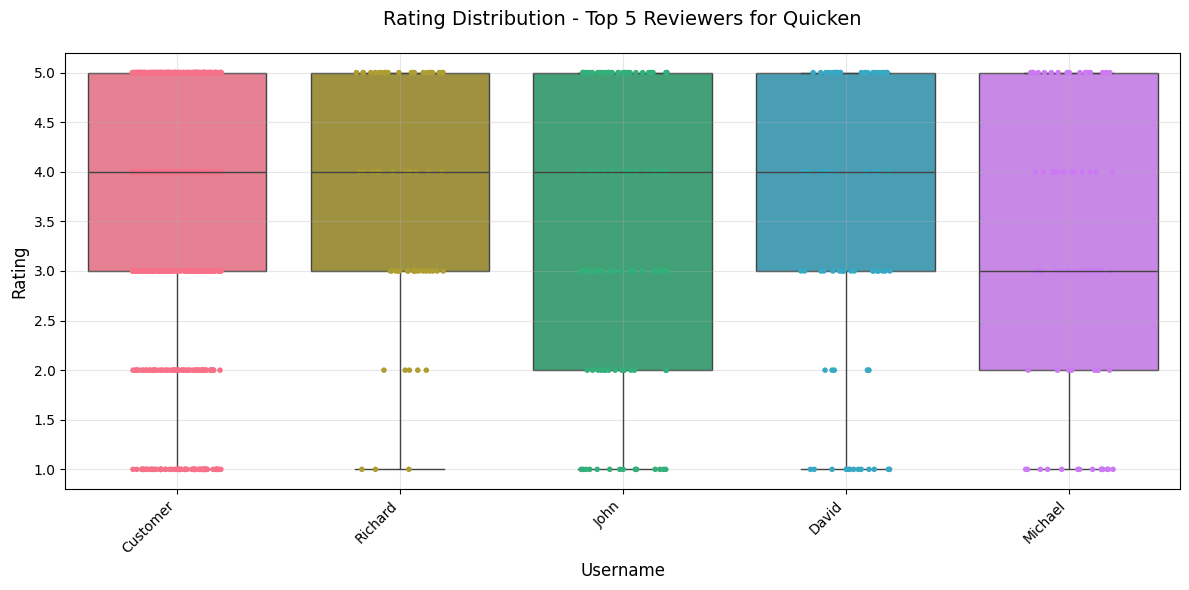

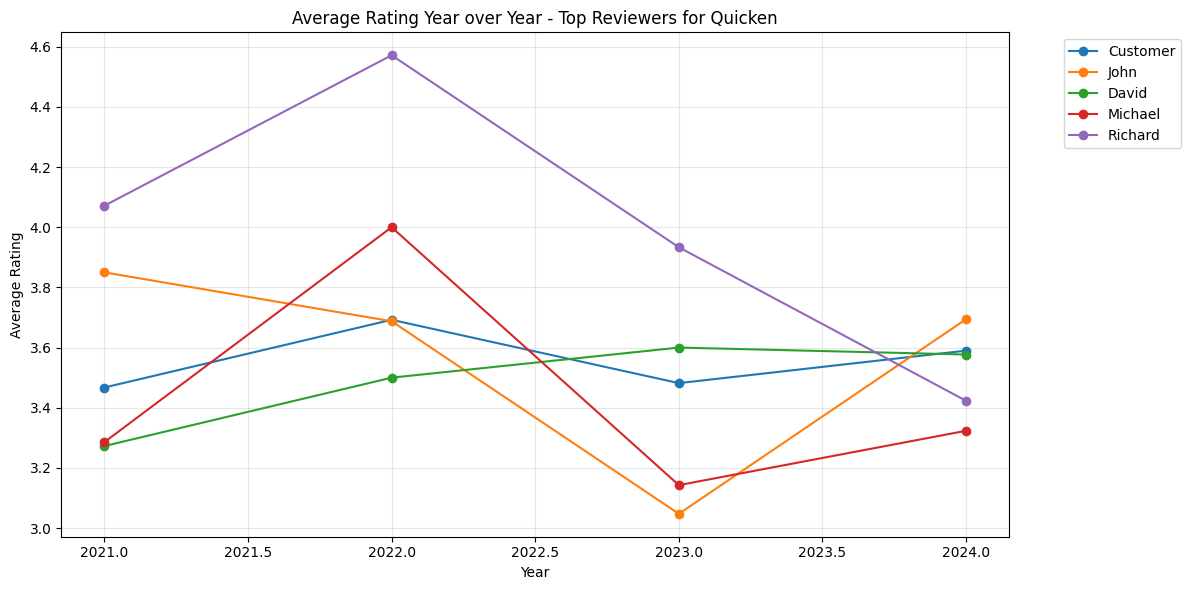

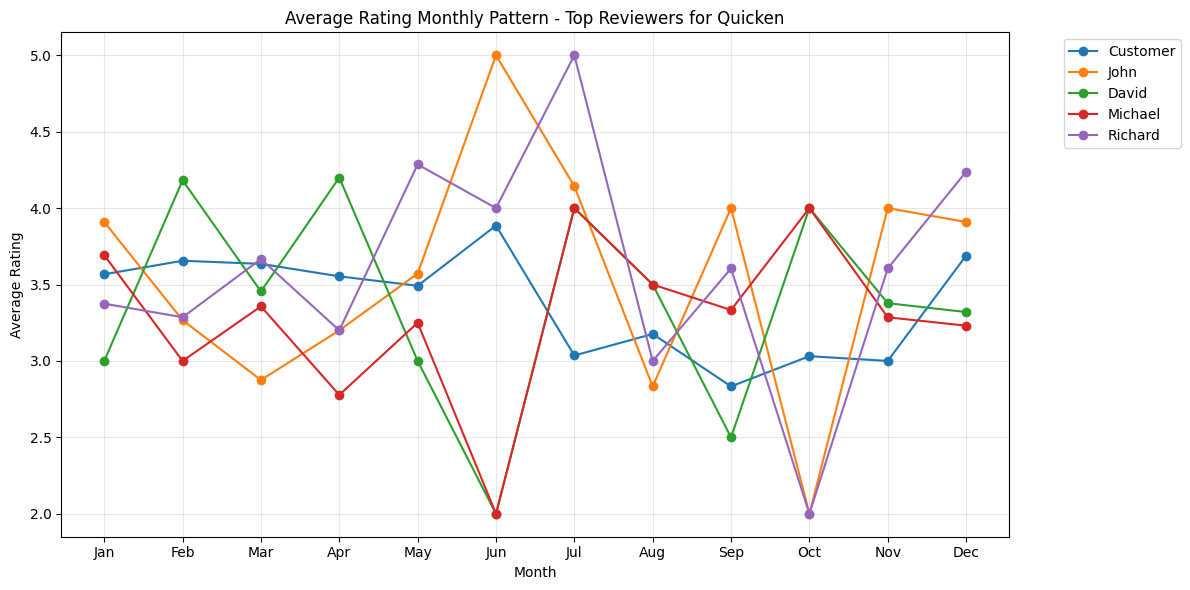


USER ANALYSIS FOR Flashbay

Top 5 reviewers for Flashbay:
username
Customer          153
Jessica            21
Chris              18
Happy Customer     17
Brian              16
Name: count, dtype: int64

Reviewer Metrics for Flashbay:
                Total_Reviews  Avg_Rating  Std_Rating  Median_Rating  Pct_Verified  Pct_Repeat_Reviewer
username                                                                                               
Brian                      16       4.938       0.250            5.0         1.000                0.250
Chris                      18       5.000       0.000            5.0         0.944                0.167
Customer                  153       4.967       0.212            5.0         0.987                0.183
Happy Customer             17       5.000       0.000            5.0         1.000                0.118
Jessica                    21       5.000       0.000            5.0         1.000                0.143


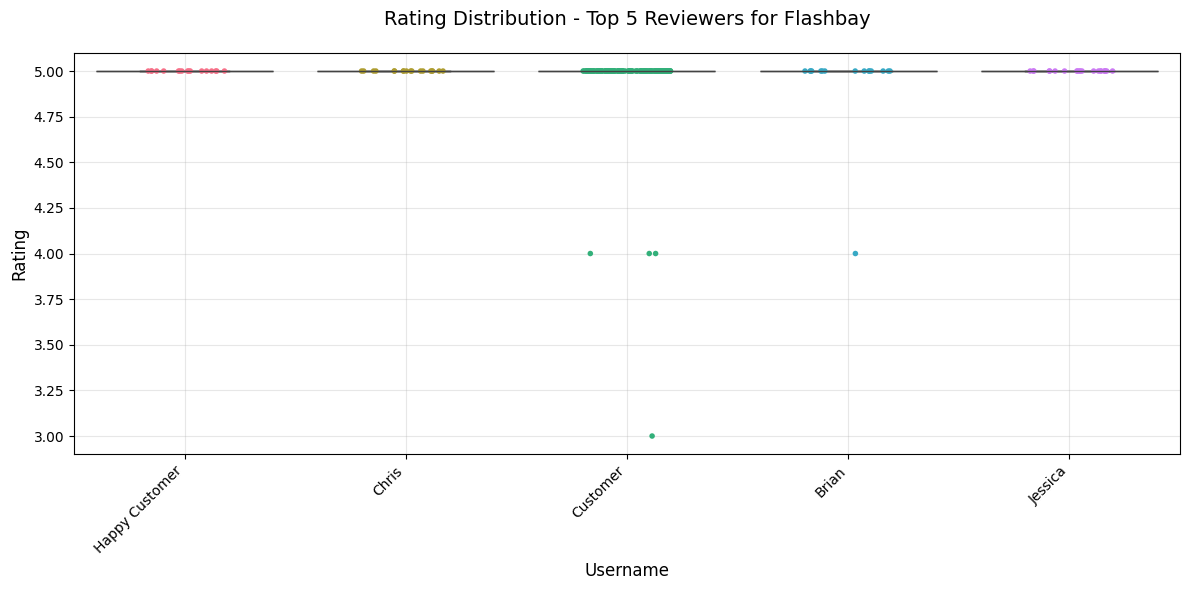

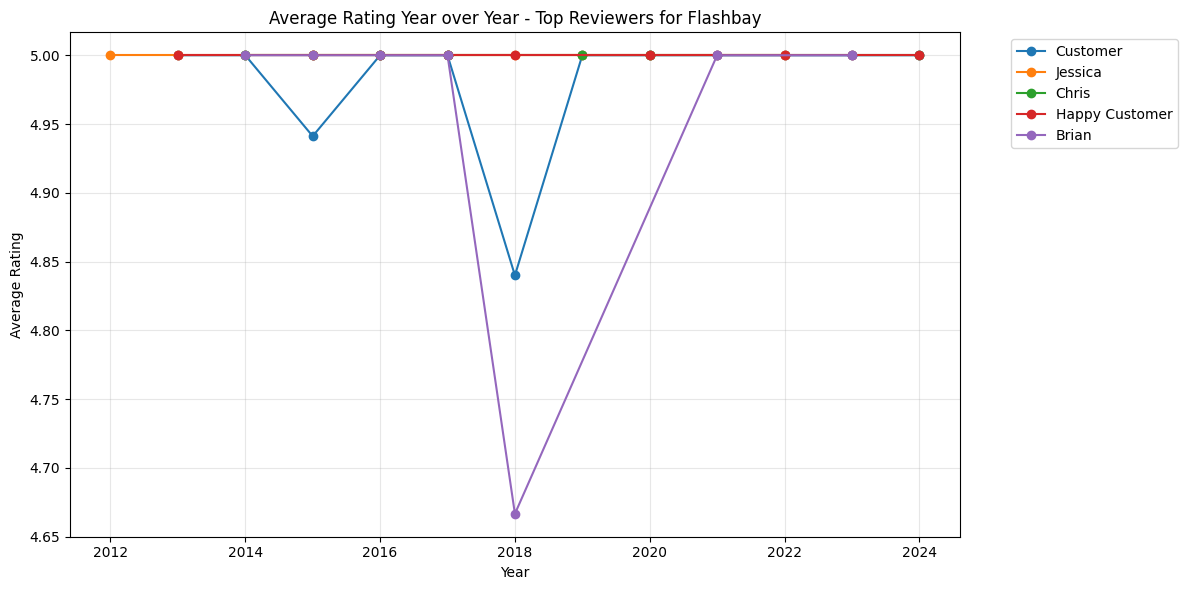

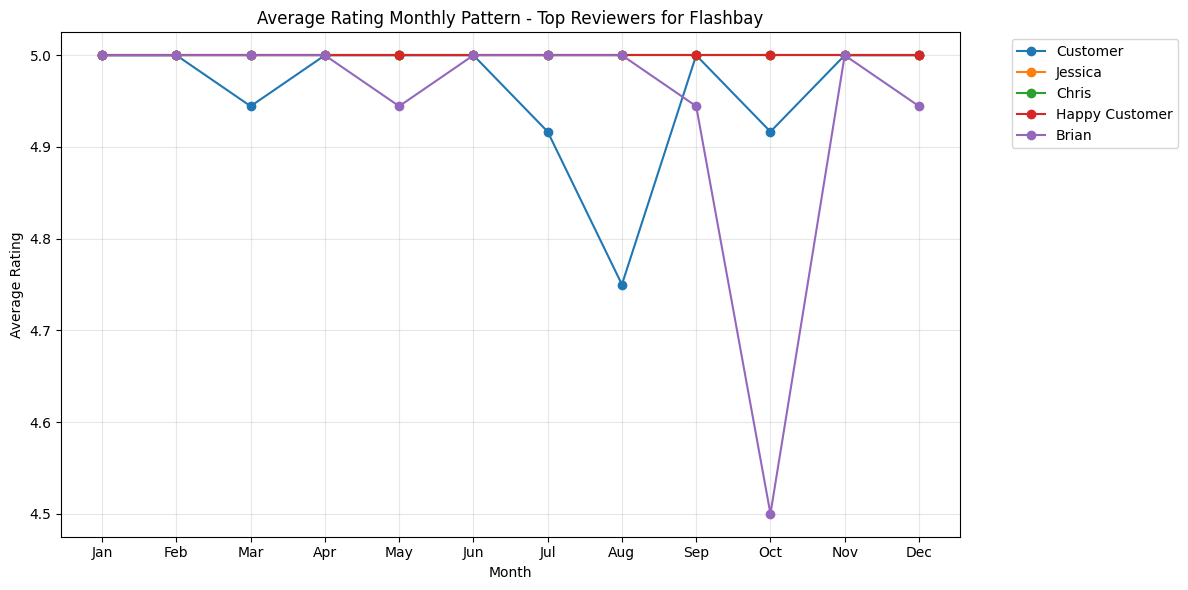


USER ANALYSIS FOR Asda

Top 5 reviewers for Asda:
username
Customer    185
Paul         50
Consumer     48
John         41
David        34
Name: count, dtype: int64

Reviewer Metrics for Asda:
          Total_Reviews  Avg_Rating  Std_Rating  Median_Rating  Pct_Verified  Pct_Repeat_Reviewer
username                                                                                         
Consumer             48       1.417       1.088            1.0           0.0                0.625
Customer            185       1.514       1.203            1.0           0.0                0.973
David                34       2.235       1.653            1.0           0.0                0.971
John                 41       1.829       1.465            1.0           0.0                0.976
Paul                 50       1.500       1.165            1.0           0.0                0.920


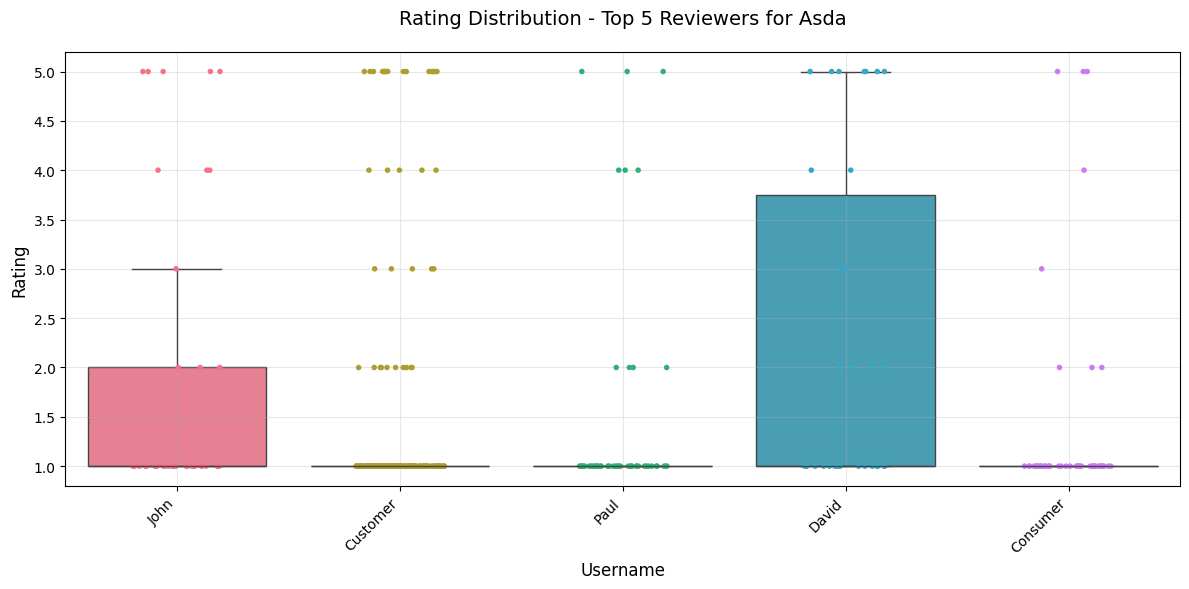

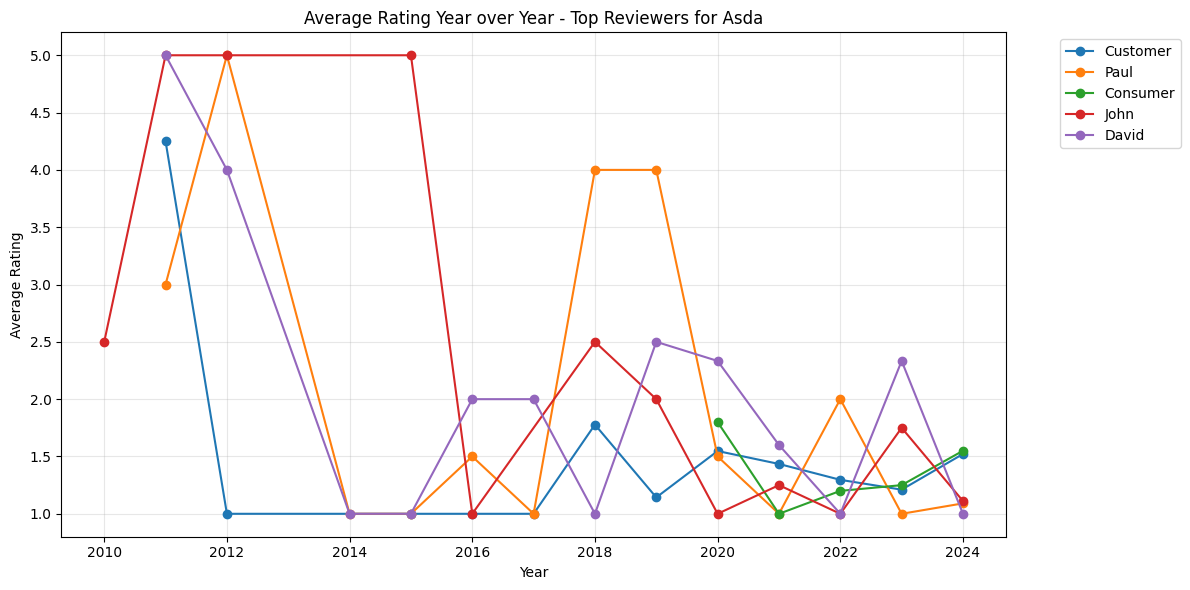

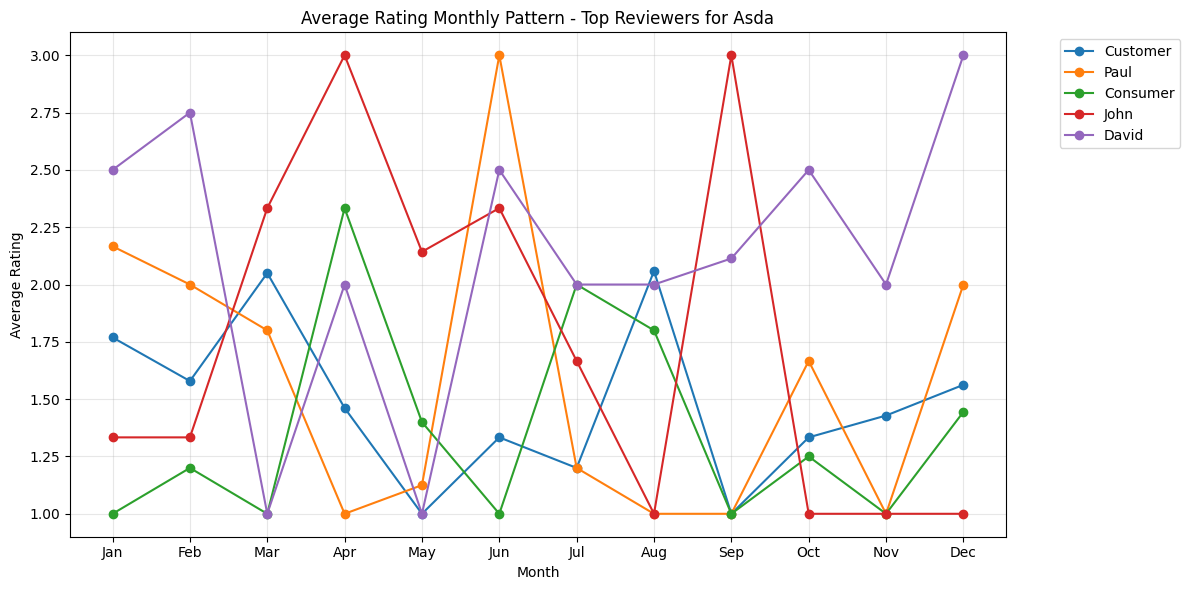


USER ANALYSIS FOR SteelSeries

Top 5 reviewers for SteelSeries:
username
Customer    144
Alex         61
Chris        59
Daniel       54
David        51
Name: count, dtype: int64

Reviewer Metrics for SteelSeries:
          Total_Reviews  Avg_Rating  Std_Rating  Median_Rating  Pct_Verified  Pct_Repeat_Reviewer
username                                                                                         
Alex                 61       3.934       1.548            5.0         0.770                0.262
Chris                59       3.407       1.782            4.0         0.831                0.288
Customer            144       3.778       1.623            5.0         0.750                0.653
Daniel               54       3.556       1.723            4.0         0.685                0.352
David                51       3.941       1.555            5.0         0.863                0.333


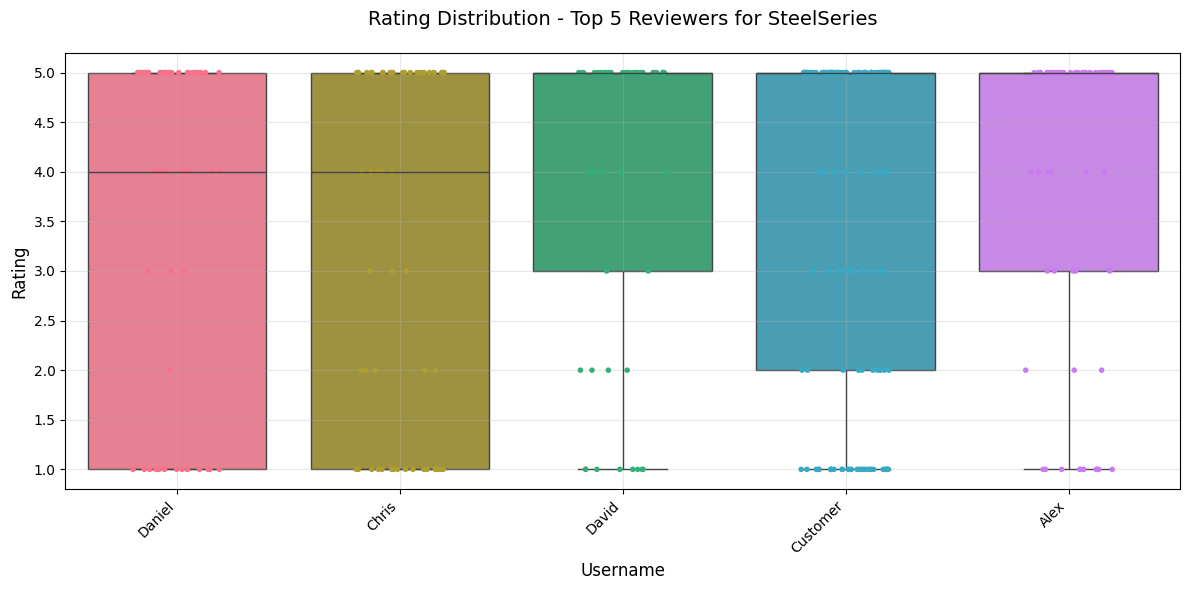

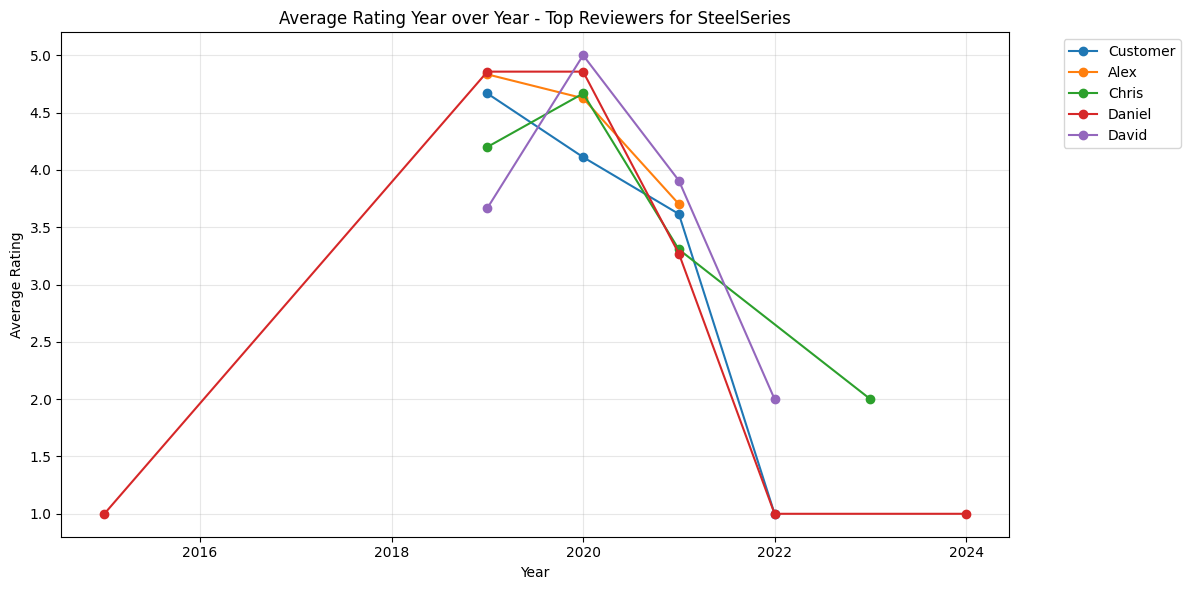

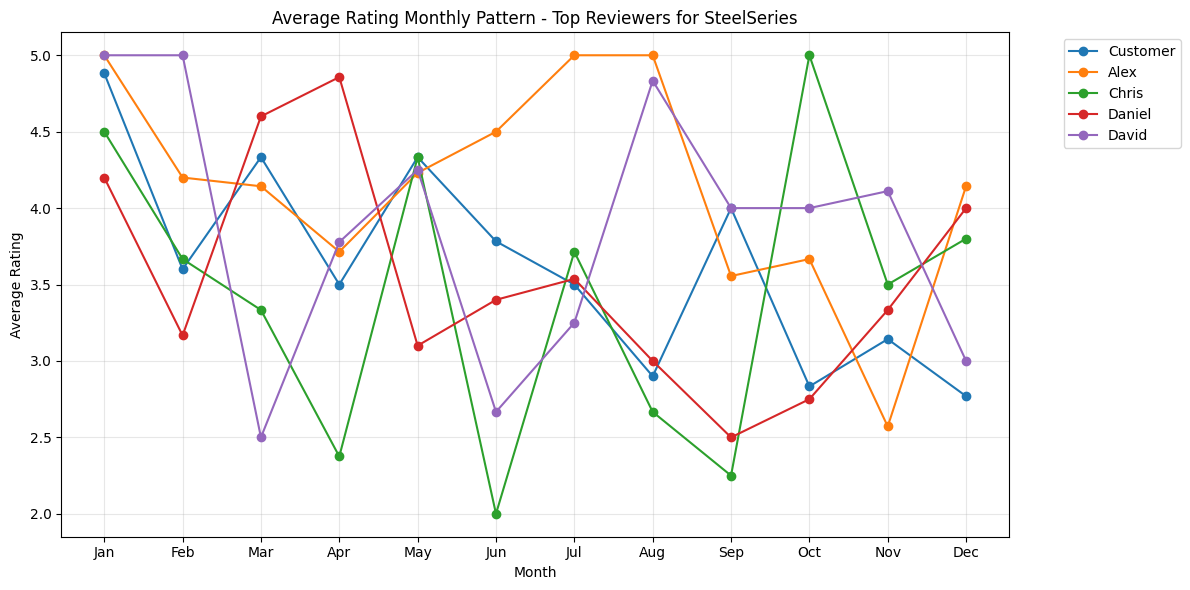

In [296]:
# username
print("USERNAME ANALYSIS")
print("="*80)

top_companies = df_trustpilot['company'].value_counts().head(10)
print("Analyzing user patterns for top 10 companies:")
print(top_companies)

for company in top_companies.index:
    print(f"{'='*50}")
    print(f"USER ANALYSIS FOR {company}")
    print(f"{'='*50}")
    
    company_data = df_trustpilot[df_trustpilot['company'] == company]
    
    top_company_users = company_data['username'].value_counts().head(5)
    print(f"Top 5 reviewers for {company}:")
    print(top_company_users)
    
    df_filtered = company_data[company_data['username'].isin(top_company_users.index)]
    
    user_analysis = df_filtered.groupby('username').agg({
        'rating': ['count', 'mean', 'std', 'median'],
        'verification': 'mean',
        'repeat_reviewer_encoded': 'mean'
    }).round(3)
    
    # Rename columns
    user_analysis.columns = ['Total_Reviews', 'Avg_Rating', 'Std_Rating', 'Median_Rating', 
                           'Pct_Verified', 'Pct_Repeat_Reviewer']
    print(f"Reviewer Metrics for {company}:")
    print(user_analysis)
    
    # Rating distribution plot
    plt.figure(figsize=(12, 6))
    colors = sns.color_palette("husl", n_colors=len(top_company_users))
    
 
    sns.boxplot(x='username', y='rating', data=df_filtered,
                palette=colors,
                boxprops={'zorder': 1},
                showfliers=False)
    
    sns.stripplot(x='username', y='rating', data=df_filtered,
                  palette=colors,
                  size=4,
                  jitter=0.2,
                  zorder=2)
    
    plt.title(f'Rating Distribution - Top 5 Reviewers for {company}', fontsize=14, pad=20)
    plt.xlabel('Username', fontsize=12)
    plt.ylabel('Rating', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Year over Year Analysis
    plt.figure(figsize=(12, 6))
    for user in top_company_users.index:
        user_data = df_filtered[df_filtered['username'] == user]
        yearly_avg = user_data.groupby(
            user_data['local_date_posted'].dt.year)['rating'].mean()
        plt.plot(yearly_avg.index, yearly_avg.values, marker='o', label=user)
    
    plt.title(f'Average Rating Year over Year - Top Reviewers for {company}')
    plt.xlabel('Year')
    plt.ylabel('Average Rating')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Monthly Pattern Analysis
    plt.figure(figsize=(12, 6))
    months = range(1, 13)
    
    for user in top_company_users.index:
        user_data = df_filtered[df_filtered['username'] == user]
        monthly_avg = pd.DataFrame(index=months)
        user_monthly = user_data.groupby(
            user_data['local_date_posted'].dt.month)['rating'].mean()
        monthly_avg['rating'] = user_monthly
        plt.plot(months, monthly_avg['rating'].fillna(monthly_avg['rating'].mean()), 
                marker='o', label=user)
    
    plt.title(f'Average Rating Monthly Pattern - Top Reviewers for {company}')
    plt.xlabel('Month')
    plt.ylabel('Average Rating')
    plt.xticks(months, 
              ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
               'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    

In [297]:
# company
print("COMPANY ANALYSIS - UNIQUE PATTERNS")
print("="*80)

top_companies = df_trustpilot['company'].value_counts().head(10)
df_filtered = df_trustpilot[df_trustpilot['company'].isin(top_companies.index)]

company_analysis = df_filtered.groupby('company').agg({
    'rating': ['count', 'mean', 'std'],
    'verification': 'mean',
    'repeat_reviewer_encoded': 'mean',
    'username': 'nunique',  
    'location': lambda x: x.nunique(),  
    'local_hour': lambda x: x.mode()[0],  
    'review_time': 'mean' 
}).round(3)

company_analysis.columns = ['Total_Reviews', 'Avg_Rating', 'Rating_Std', 
                          'Verification_Rate', 'Repeat_Reviewer_Rate',
                          'Unique_Reviewers', 'Countries_Present', 
                          'Peak_Hour', 'Avg_Review_Time']

print("Customer Base Analysis:")
for company in top_companies.index:
    company_data = df_filtered[df_filtered['company'] == company]
    
    reviews_per_user = company_data.groupby('username').size()
    
    print(f"{company}:")
    print(f"Total Reviews: {len(company_data):,}")
    print(f"Unique Reviewers: {len(reviews_per_user):,}")
    print(f"Reviews per Customer: {reviews_per_user.mean():.2f}")
    print(f"One-time Reviewers: {(reviews_per_user == 1).sum():,} ({(reviews_per_user == 1).mean()*100:.1f}%)")
    print(f"Loyal Customers (>5 reviews): {(reviews_per_user > 5).sum():,}")
    print(f"Countries: {company_data['location'].nunique()}")
    print(f"Most Common Country: {company_data['location'].mode()[0]}")

COMPANY ANALYSIS - UNIQUE PATTERNS

Customer Base Analysis:

Quicken:
Total Reviews: 29,466
Unique Reviewers: 24,569
Reviews per Customer: 1.20
One-time Reviewers: 23,456 (95.5%)
Loyal Customers (>5 reviews): 208
Countries: 93
Most Common Country: US

Flashbay:
Total Reviews: 17,675
Unique Reviewers: 16,198
Reviews per Customer: 1.09
One-time Reviewers: 15,650 (96.6%)
Loyal Customers (>5 reviews): 73
Countries: 64
Most Common Country: US

Asda:
Total Reviews: 15,657
Unique Reviewers: 12,886
Reviews per Customer: 1.21
One-time Reviewers: 12,110 (94.0%)
Loyal Customers (>5 reviews): 155
Countries: 52
Most Common Country: GB

SteelSeries:
Total Reviews: 15,606
Unique Reviewers: 12,350
Reviews per Customer: 1.26
One-time Reviewers: 11,579 (93.8%)
Loyal Customers (>5 reviews): 154
Countries: 128
Most Common Country: US


In [ ]:
#Inspecting final output 

print(df_trustpilot.columns)
print(df_trustpilot.info())
print("The Trustpilot dataset has ", df_trustpilot.shape[1], "columns")
print("The Trustpilot dataset has ", df_trustpilot.shape[0], "rows")
display(df_trustpilot.head())

In [298]:
import os

os.makedirs('data', exist_ok=True)

csv_path = 'data/data_trustpilot_2.csv'
df_trustpilot.to_csv(csv_path, index=False)
print(f"DataFrame exported to {csv_path}")

DataFrame exported to data/data_trustpilot_2.csv
